In [1]:
%matplotlib inline

import pandas as pd, numpy as np
import matplotlib.pyplot as plt, scipy.stats as st
import seaborn as sns
sns.set(style='darkgrid')
from gbd_mapping import causes
from db_queries import get_outputs, get_ids
from matplotlib.backends.backend_pdf import PdfPages
import warnings
warnings.filterwarnings('ignore')
!date
!whoami
#This notebook revised from Yongquan's data processing and validation notebooks 

Mon Apr  6 11:25:09 PDT 2020
yaqiw


In [2]:
result_dir = '/ihme/costeffectiveness/results/vivarium_conic_lsff/v5.0_vitamin_a_fortification/'
Ethiopia_filePath = {'deaths': result_dir + 'ethiopia/2020_03_26_08_33_10/count_data/deaths.hdf',
                    'person_time': result_dir + 'ethiopia/2020_03_26_08_33_10/count_data/person_time.hdf',
                    'ylds': result_dir + 'ethiopia/2020_03_26_08_33_10/count_data/ylds.hdf',
                    'ylls': result_dir + 'ethiopia/2020_03_26_08_33_10/count_data/ylls.hdf'}

India_filePath = {'deaths': result_dir + 'india/2020_03_26_21_28_29/count_data/deaths.hdf',
                  'person_time': result_dir + 'india/2020_03_26_21_28_29/count_data/person_time.hdf',
                  'ylds': result_dir + 'india/2020_03_26_21_28_29/count_data/ylds.hdf',
                  'ylls': result_dir + 'india/2020_03_26_21_28_29/count_data/ylls.hdf'}

Nigeria_filePath = {'deaths': result_dir + 'nigeria/2020_03_24_23_27_55/count_data/deaths.hdf',
                  'person_time': result_dir + 'nigeria/2020_03_24_23_27_55/count_data/person_time.hdf',
                  'ylds': result_dir + 'nigeria/2020_03_24_23_27_55/count_data/ylds.hdf',
                  'ylls': result_dir + 'nigeria/2020_03_24_23_27_55/count_data/ylls.hdf'}
filePath = {'Ethiopia' : Ethiopia_filePath, 'India' : India_filePath, 'Nigeria' :Nigeria_filePath}
cause_names = ['vitamin_a_deficiency', 'measles', 'diarrheal_diseases', 'lower_respiratory_infections', 'dietary_iron_deficiency', 'neural_tube_defects']

### 1. Data Processing

In [3]:
def dataAggregate(df: pd.DataFrame, by_cause=False):
    cause_col = ['cause'] if by_cause else []
    df = df.loc[df['scenario'] == 'baseline']
    allPop_aggregate = df.groupby(cause_col + ['sex', 'age_group', 'measure', 'input_draw']).value.sum().reset_index()
    allPop_aggregate['vitamin_a_fortification_group'] = 'all_population'
    df = pd.concat([df, allPop_aggregate])
    return df.reset_index().drop(columns = ['index', 'scenario', 'year'])

In [4]:
def processData(location_filePath):
    df_deaths = pd.read_hdf(location_filePath['deaths']).drop(columns = 'folic_acid_fortification_group')
    df_deaths['measure'] = 'deaths'
    df_ylds = pd.read_hdf(location_filePath['ylds']).drop(columns = 'folic_acid_fortification_group')
    df_ylds['measure'] = 'ylds'
    df_ylls = pd.read_hdf(location_filePath['ylls']).drop(columns = 'folic_acid_fortification_group')
    df_ylls['measure'] = 'ylls'
    df_result = pd.concat([df_deaths, df_ylls, df_ylds])
    df_result = dataAggregate(df_result, by_cause = True)
    #get and process person time data
    df_pt = pd.read_hdf(location_filePath['person_time']).drop(columns = 'folic_acid_fortification_group')
    df_pt = dataAggregate(df_pt, by_cause = False)
    df_pt = df_pt.rename(columns={'value':'person_time'}).drop(columns = 'measure')
    #merge person-time 
    df_final = pd.merge(df_result, df_pt, on=['age_group', 'sex', 'input_draw', 'vitamin_a_fortification_group'])
    df_final['cause']= df_final['cause'].replace("iron_deficiency", "dietary_iron_deficiency")
    df_final['sex'] = df_final['sex'].replace({'female':'Female', 'male':'Male'})
    #df_final['rate'] = df_final['value'] /df_final['person_time'] * 100_000
    #g = df_final.groupby(['cause', 'sex', 'age_group', 'measure'])[['value', 'rate', 'person_time']].describe(percentiles=[.025, .975])
    #t = g.loc[:, pd.IndexSlice[:, ['mean', '2.5%', '97.5%']]]
    #t.columns = [f'{metric}_{val}' for metric, val in zip(t.columns.get_level_values(0), t.columns.get_level_values(1))]
    #return t.reset_index()
    return df_final

### 2. Validation

In [5]:
gbd_names = ['vitamin_a_deficiency', 'measles', 'diarrheal_diseases', 'lower_respiratory_infections', 'dietary_iron_deficiency', 
             'neural_tube_defects']

In [6]:
age_group_ids = list(range(2, 6)) 
age_table = get_ids('age_group')
age_table = age_table[age_table.age_group_id.isin(age_group_ids)]
age_table['age_group_name'] = age_table.age_group_name.map(lambda x: x.replace(' ', '_').lower())

age_dict = dict(zip(age_table.age_group_name, age_table.age_group_id))

In [7]:
def get_gbd_results(location_id: int, cause_names: list):
    ages = age_group_ids
    male, female, both = 1, 2, 3
    rate = 3
    deaths, ylds, ylls = 1, 3, 4
    
    cause_map = {c.gbd_id: c.name for c in causes if c.name in cause_names}

    gbd_outputs = get_outputs('cause', cause_id=list(cause_map.keys()), 
                              metric_id=[rate], measure_id=[deaths, ylls, ylds], 
                              sex_id = [male, female, both], age_group_id=ages,
                              location_id=location_id, gbd_round_id=5)


    gbd_outputs = gbd_outputs[['cause_id', 'age_group_name', 'measure_name', 'sex', 'val', 'upper', 'lower']]
    gbd_outputs['cause'] = gbd_outputs.cause_id.map(cause_map)
    gbd_outputs['measure'] = gbd_outputs.measure_name.map({'Deaths': 'deaths',
                                                           'YLLs (Years of Life Lost)': 'ylls',
                                                           'YLDs (Years Lived with Disability)': 'ylds'})
    gbd_outputs['age_group'] = gbd_outputs.age_group_name.str.replace(' ', '_').map(lambda x: x.lower())
    gbd_outputs = gbd_outputs.drop(columns=['cause_id', 'measure_name', 'age_group_name'])
    gbd_outputs[['val', 'upper', 'lower']] *= 100_000
    gbd_outputs = gbd_outputs.fillna(0.0)
    
    gbd_outputs = gbd_outputs.set_index(['cause', 'sex', 'measure']).sort_index().reset_index()
    
    return gbd_outputs

In [8]:
def aggregate_gbd_results(df: pd.DataFrame, cause_names: list):
    idx_cols = ['sex', 'age_group', 'measure']
    val_cols = ['val', 'upper', 'lower']
    sex = df.sex.unique()
    age_group = df.age_group.unique()
    measure = df.measure.unique()
    data = pd.DataFrame(0.0,
                        index=pd.MultiIndex.from_product([sex, age_group, measure], names=idx_cols),
                        columns=val_cols)
    for cause in cause_names:
        data += df.loc[df.cause == cause].drop(columns='cause').set_index(idx_cols)
    return data.reset_index()

In [9]:
#location_id for Nigeria is 214, for India is 163, for Ethiopia is 179

In [10]:
def make_plots(cause: str, sim_results: pd.DataFrame, gbd_results: pd.DataFrame, location: str, measure: str):
    sim_results = sim_results.loc[sim_results['vitamin_a_fortification_group'] == 'all_population']
    sim_results = sim_results.loc[sim_results.age_group.map(age_dict).sort_values().index]
    sim_results = sim_results.set_index(['cause', 'sex', 'measure','vitamin_a_fortification_group']).sort_index().reset_index()
    sim_data = sim_results.loc[sim_results.cause == cause]
    sim_data['rate'] = sim_data['value'] / sim_data['person_time'] * 100_000
    
    sim_mean = sim_data.groupby(['cause', 'sex', 'age_group', 'measure','vitamin_a_fortification_group']).rate.mean().reset_index()
    sim_mean = sim_mean.loc[sim_mean.age_group.map(age_dict).sort_values().index]
    sim_mean = sim_mean.set_index(['cause', 'sex', 'measure','vitamin_a_fortification_group']).sort_index().reset_index()
    
    gbd_data = gbd_results.loc[(gbd_results.sex != 'Both') & (gbd_results.cause == cause)]
    
    measure_s = sim_data.loc[sim_data.measure == measure]
    measure_m = sim_mean.loc[sim_mean.measure == measure]
    measure_g = gbd_data.loc[gbd_data.measure == measure]
    
    fig, ax = plt.subplots(figsize=(20, 10))
    clrs = sns.color_palette('husl', 2)

    g1 = sns.catplot(x='age_group', y='rate', 
                     hue='sex', palette=clrs, alpha=0.2, 
                     ax=ax, data=measure_s)

    sns.lineplot(x='age_group', y='val', 
                 hue='sex', palette=clrs, linewidth=2,
                 ax=ax, data=measure_g, sort=False)

    for i, sex in enumerate(['Female', 'Male']):
        sex_g = measure_g.loc[measure_g.sex == sex]
        ax.fill_between(sex_g.age_group, sex_g.upper, sex_g.lower, alpha=0.3, facecolor=clrs[i])
        
        sex_m = measure_m.loc[measure_m.sex == sex]
        ax.scatter(sex_m.age_group, sex_m.rate, s=250, color=clrs[i], marker='P', label=f'Sim {sex} mean')
        
    ax.set_title(f'{location}, {measure.capitalize()} due to {cause}', fontsize=20)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=60, fontsize=16)
    #ax.set_xticks([c-0.2 for c in range(23)])
    ax.set_xlabel('Age group', fontsize=18)
    ax.set_ylabel(f'{measure.capitalize()} per 100k PY', fontsize=18)

    l = ax.legend(loc=(1.02, 0.05), fontsize=12)
    labels = ['GBD Female', 'GBD Male', 'Sim Female', 'Sim Male']
    for text, label in zip(l.texts[1:5], labels):
        text.set_text(label)

    plt.close(g1.fig)

In [11]:
def plot_multiple_locations(path_dict: dict, cause_names: list, gbd_names: list):
    location_table = get_ids('location')
    causes = ['vitamin_a_deficiency', 'dietary_iron_deficiency','measles', 'diarrheal_diseases', 
              'lower_respiratory_infections', 'neural_tube_defects']
    measures = ['deaths', 'ylds', 'ylls']
    for location, location_filePath in path_dict.items():
        # sim results
        results_w_pt = processData(location_filePath)
        
        # gbd results
        location_id = location_table.loc[location_table.location_name == location].location_id.values
        gbd = get_gbd_results(location_id, gbd_names)
        
        with PdfPages(f'/home/j/Project/simulation_science/mnch/Interventions/large_scale_food_fortification/validation/model5/model5_validation_{location}.pdf') as pdf:
            for cause in causes:
                for measure in measures:
                    if ((cause == 'vitamin_a_deficiency') | (cause == 'dietary_iron_deficiency')) & ((measure == 'deaths')|(measure == 'ylls')):
                        continue 
                    else: 
                        make_plots(cause, results_w_pt, gbd, location, measure)
                        pdf.savefig(bbox_inches='tight')

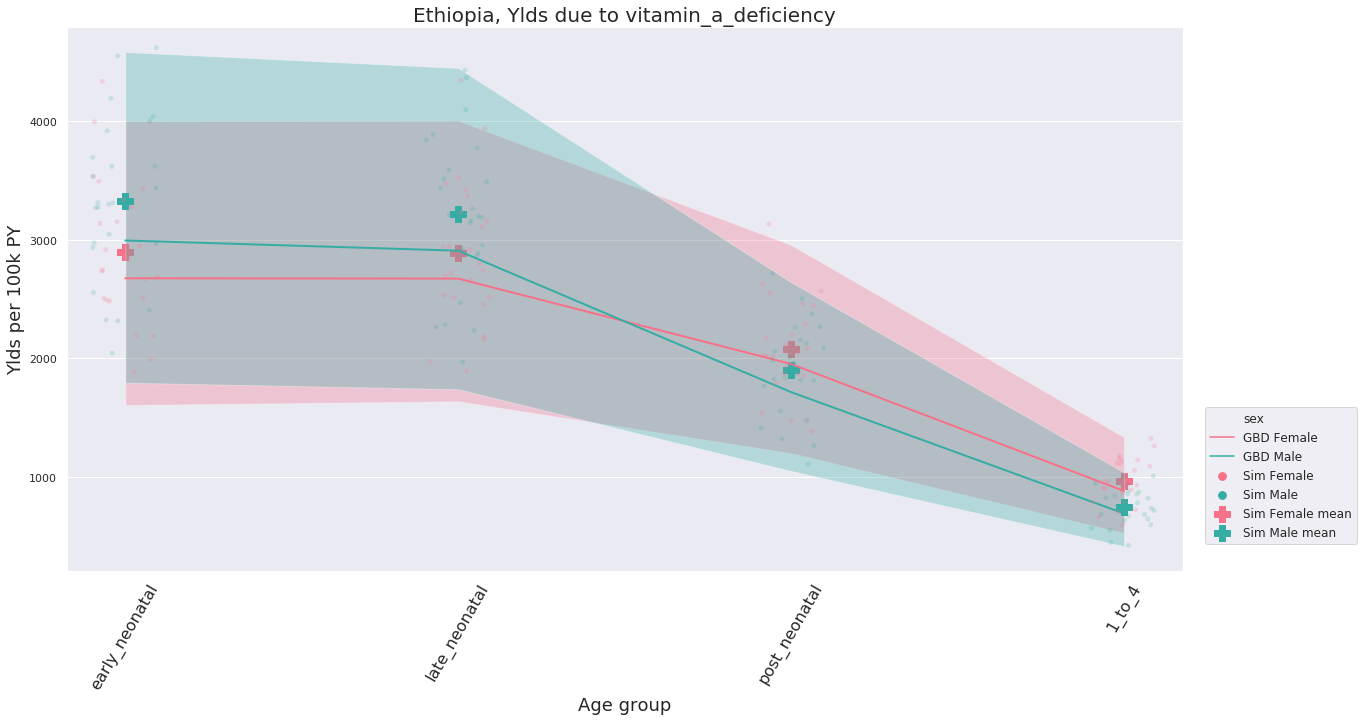

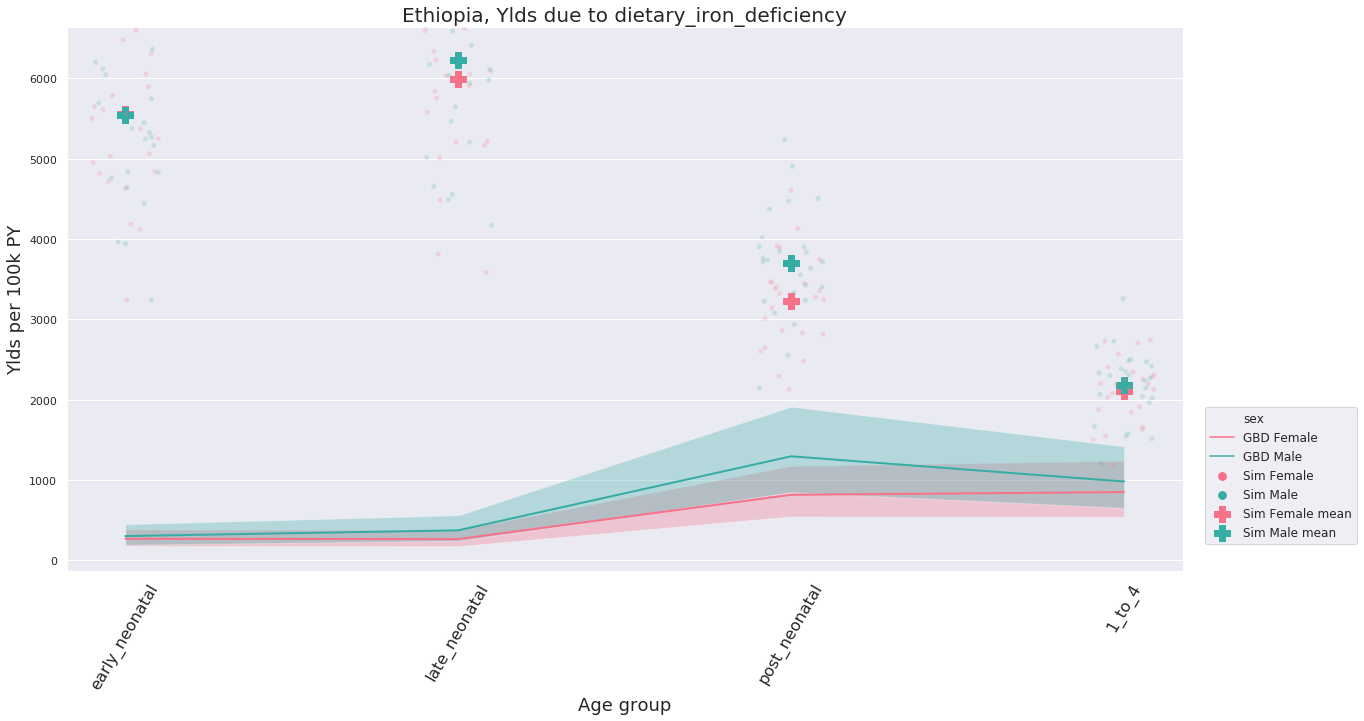

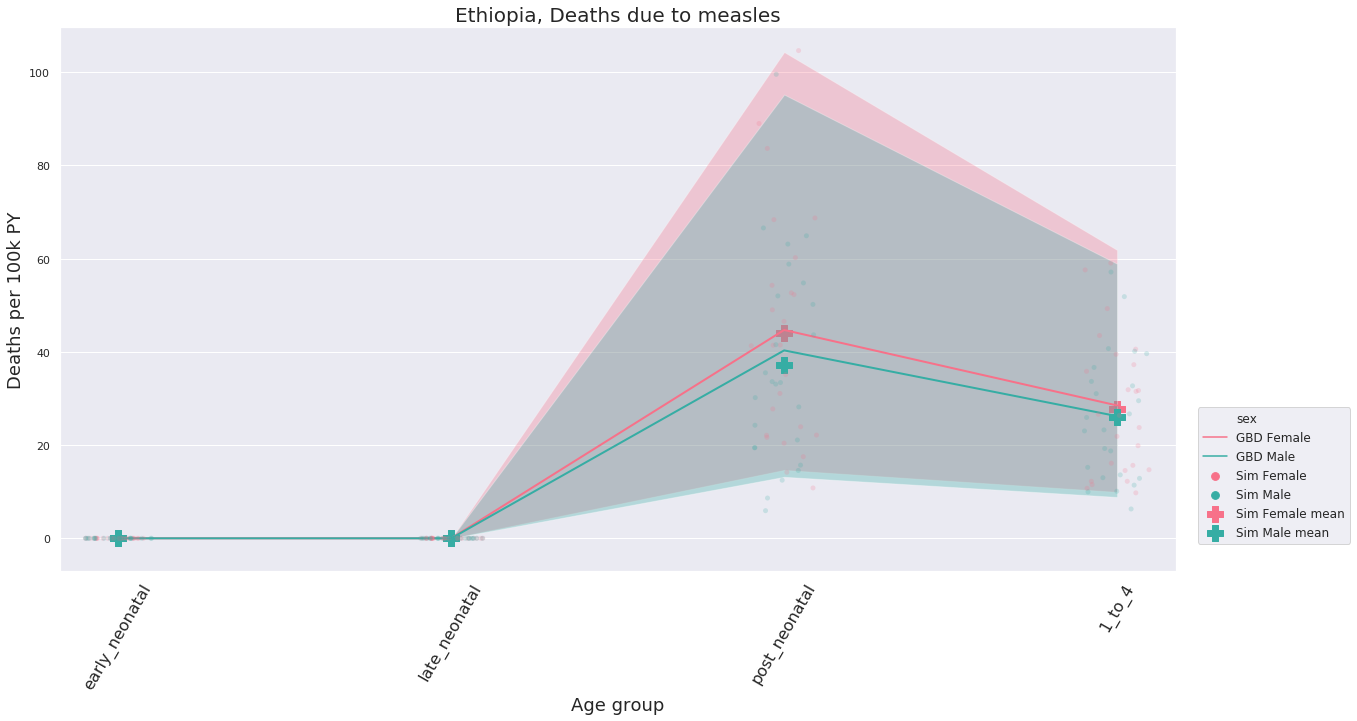

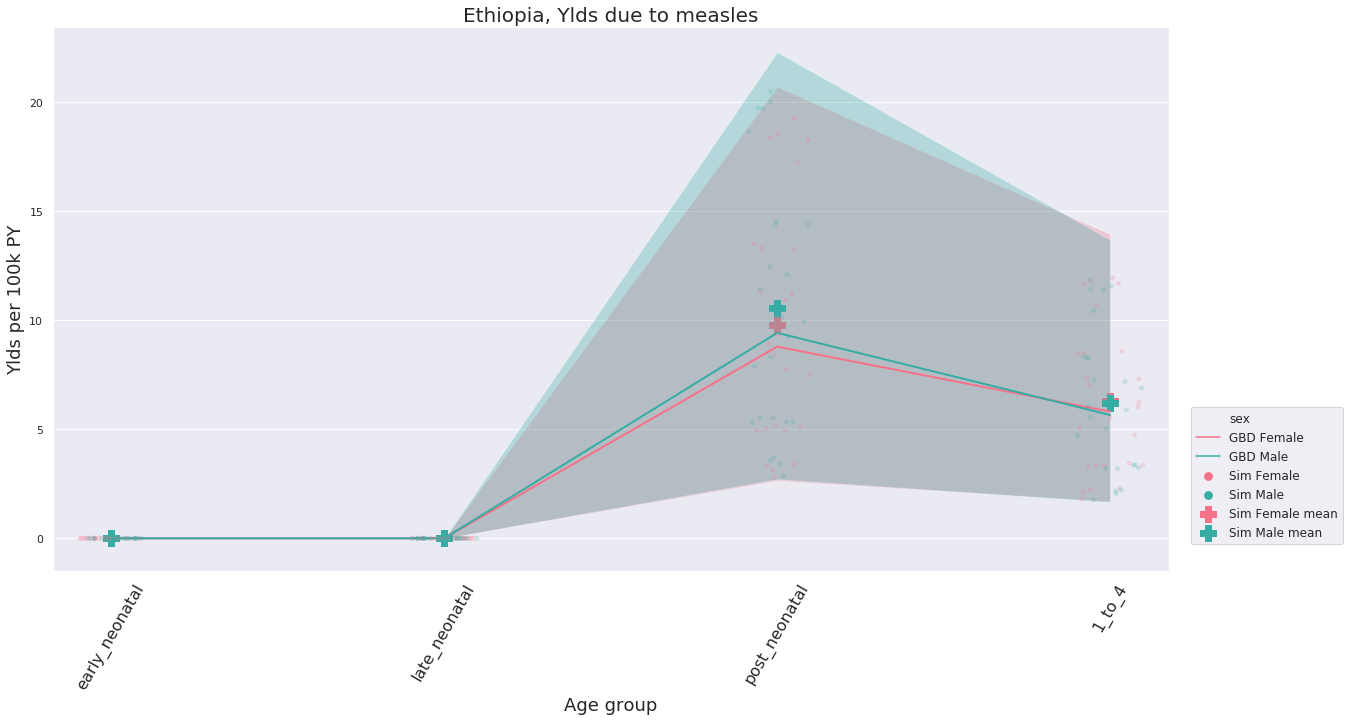

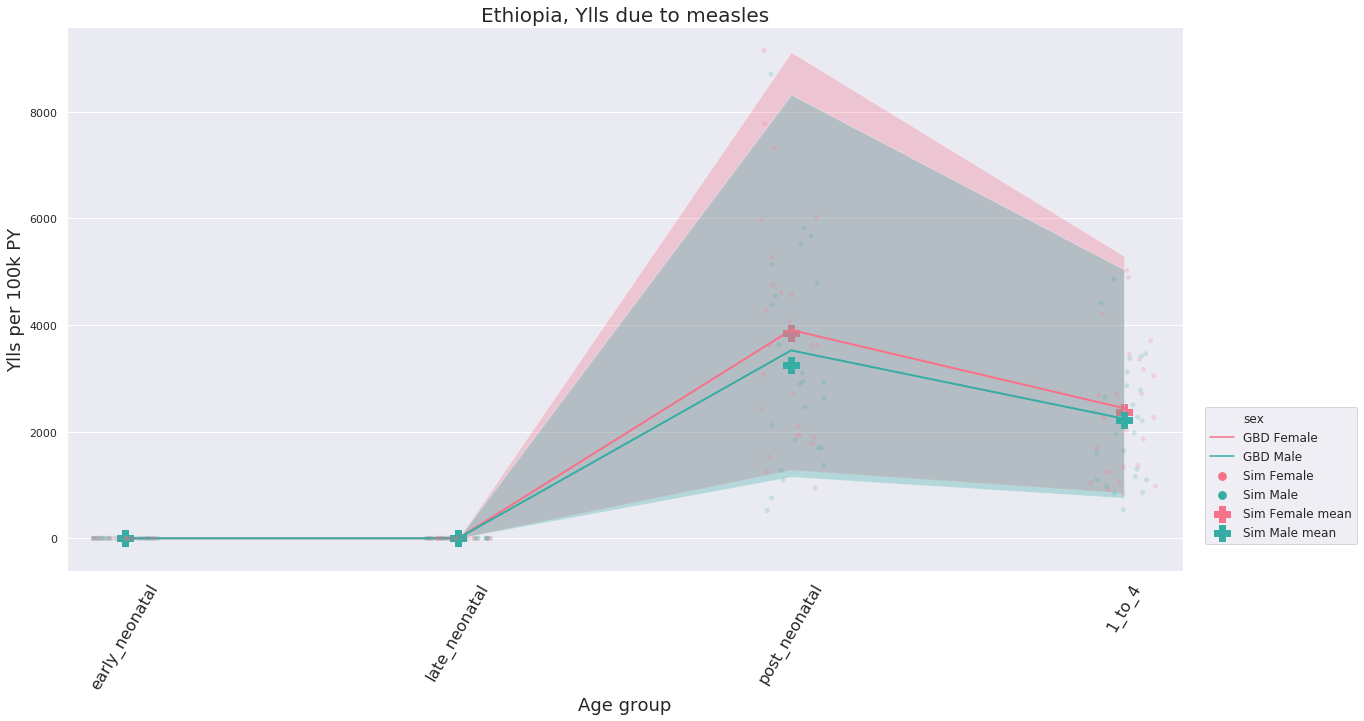

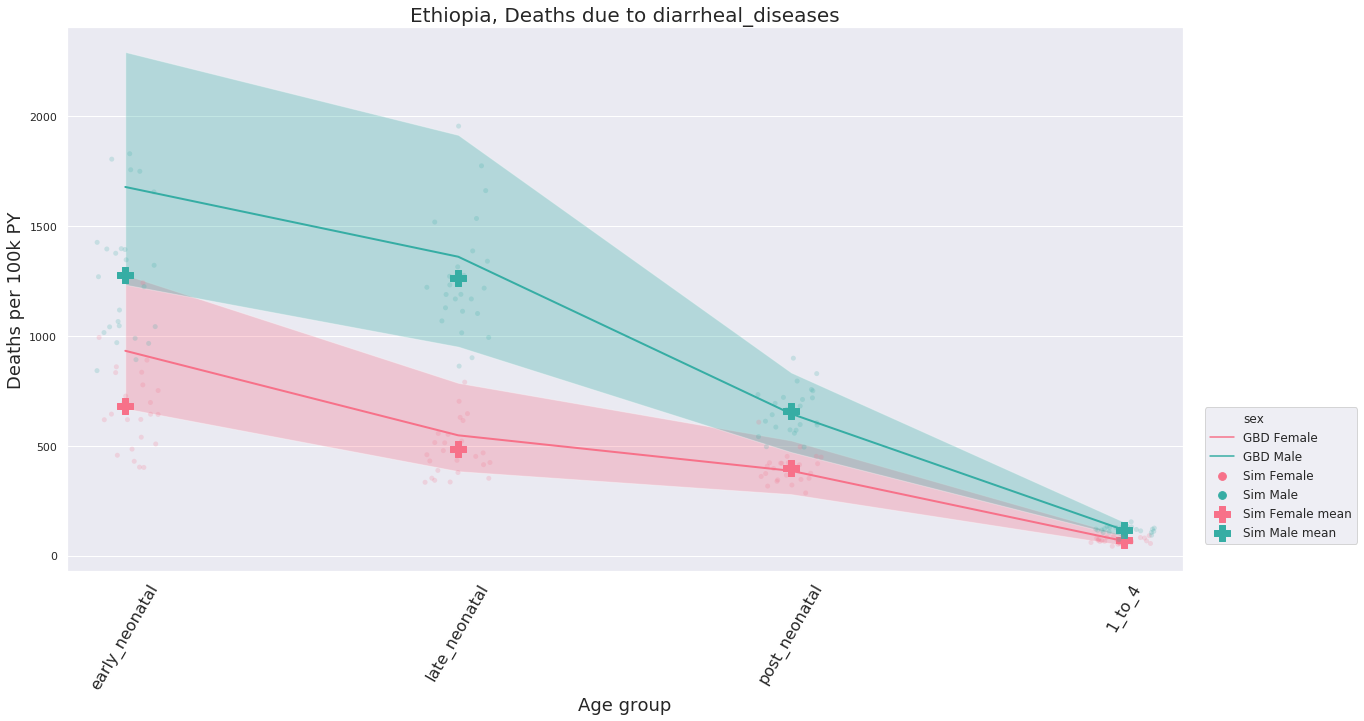

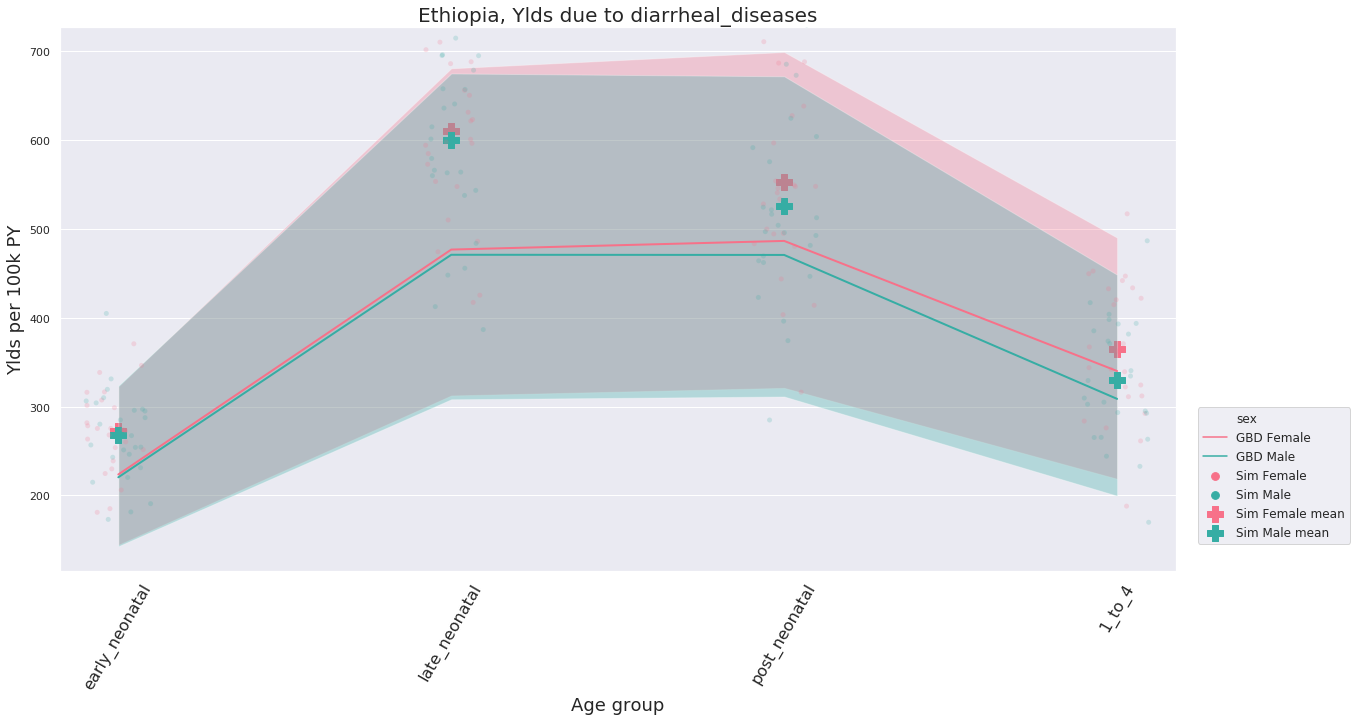

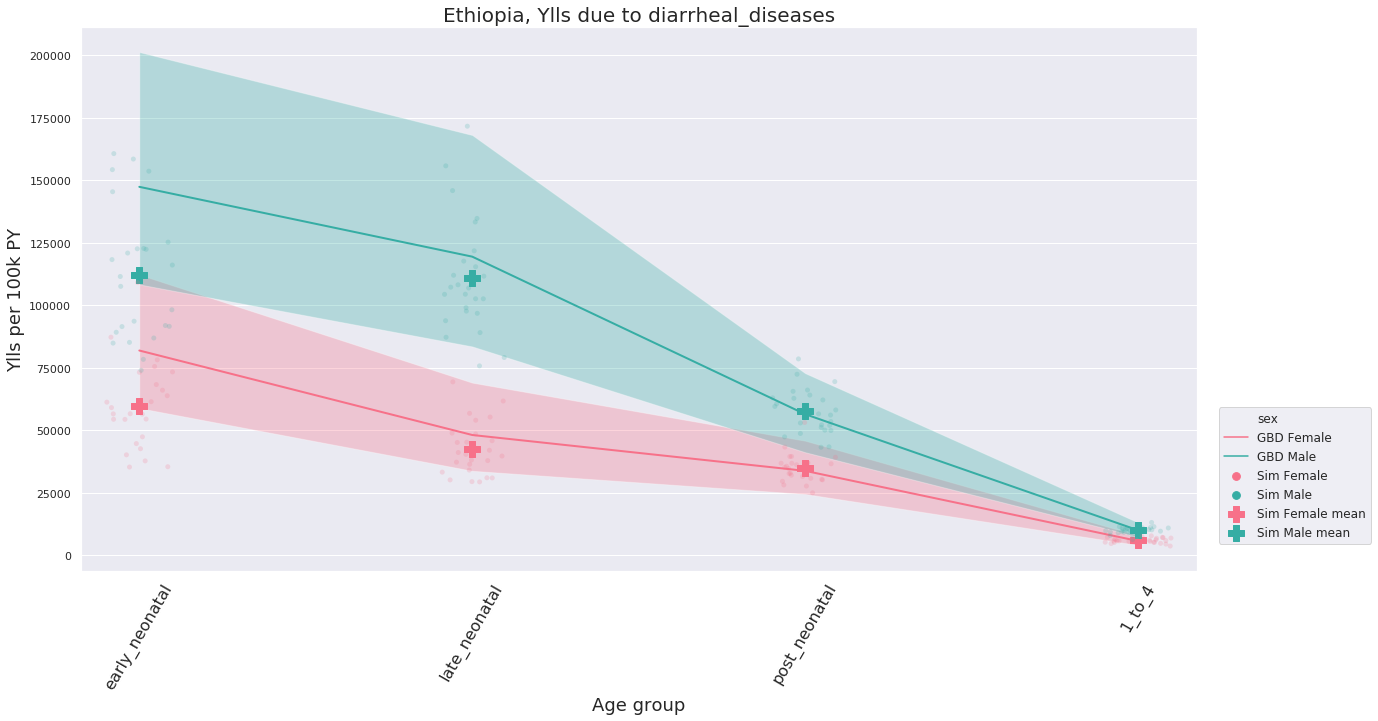

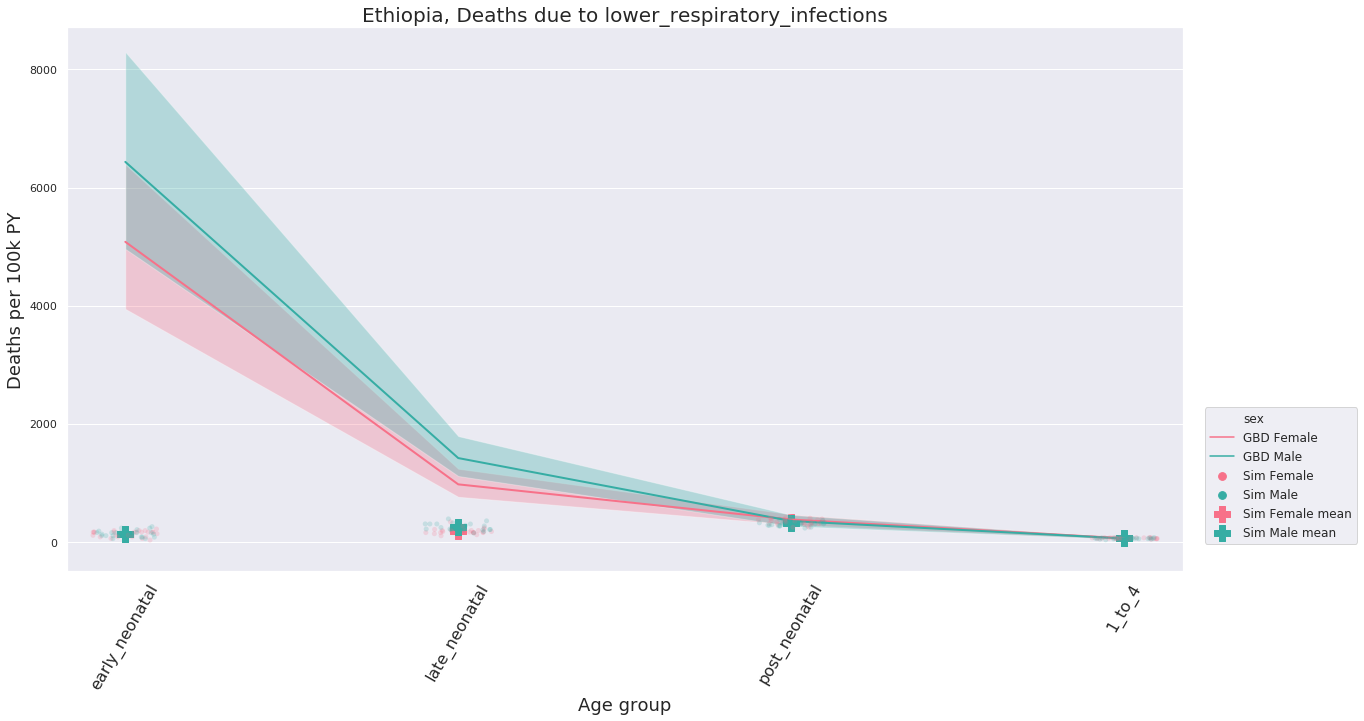

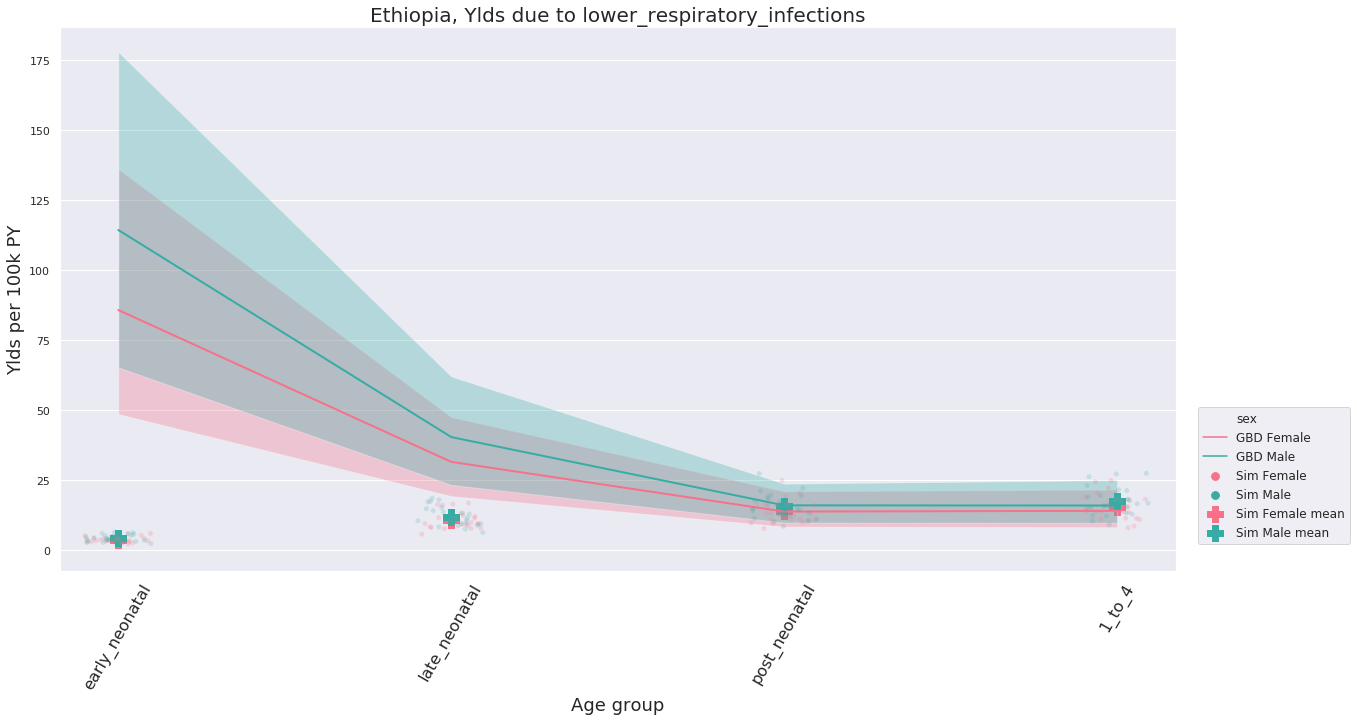

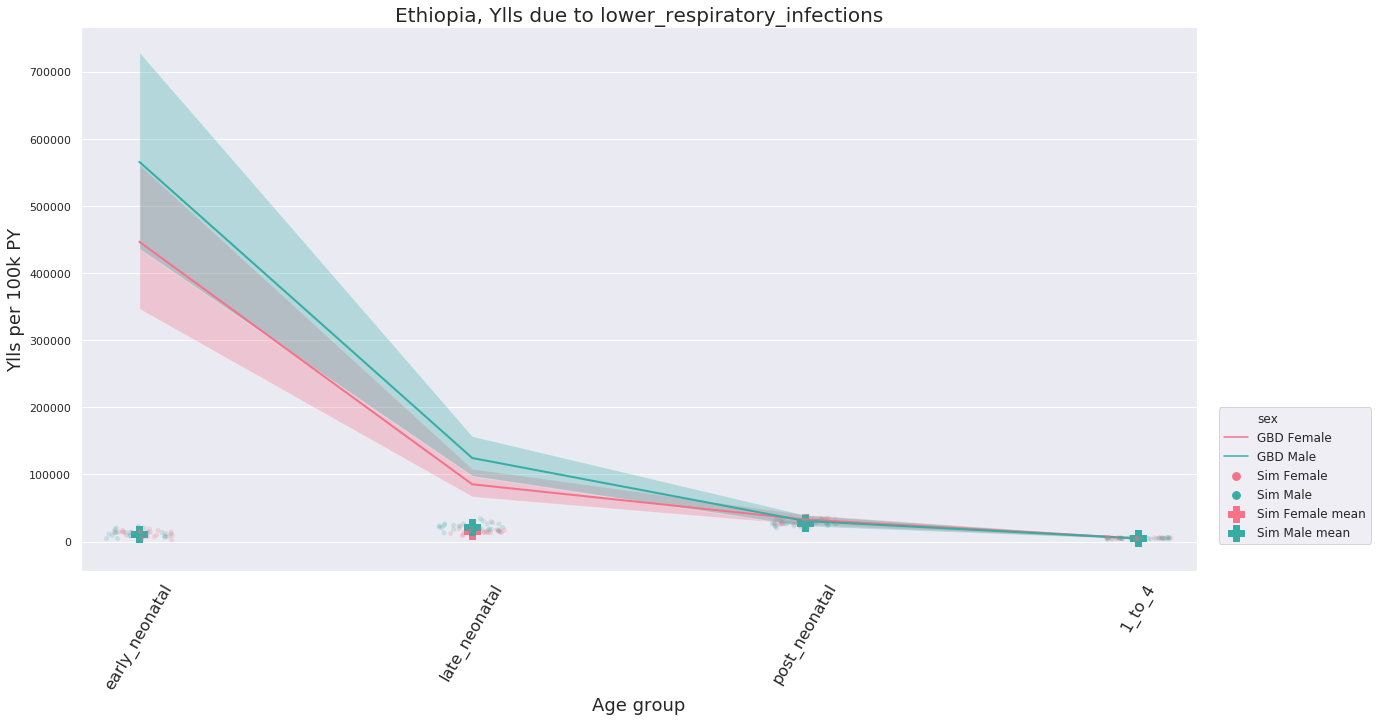

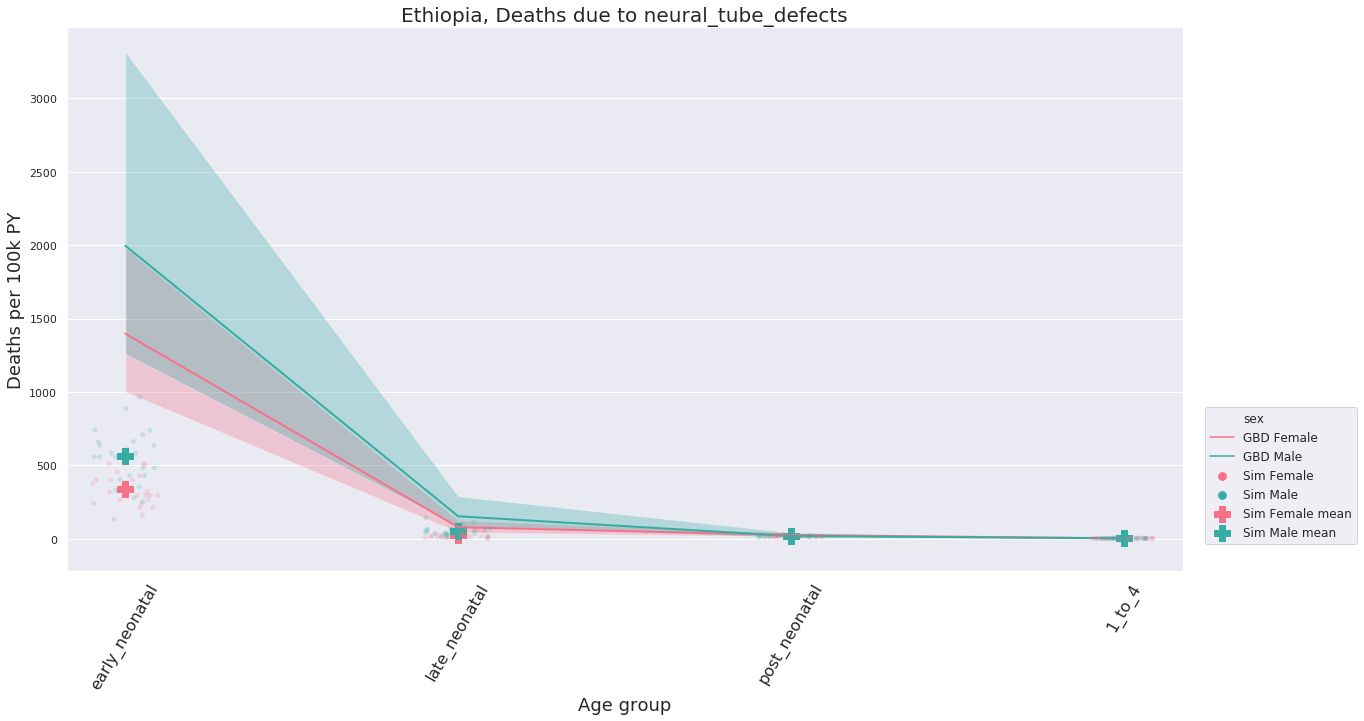

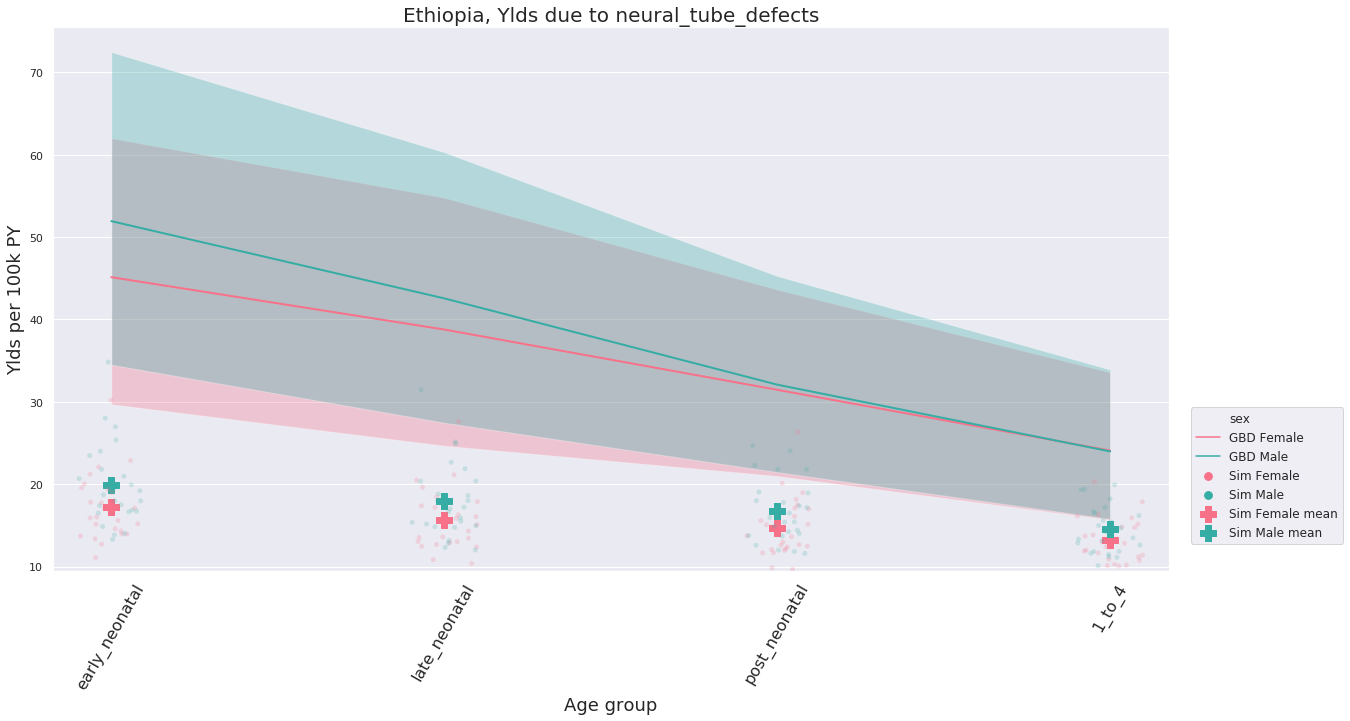

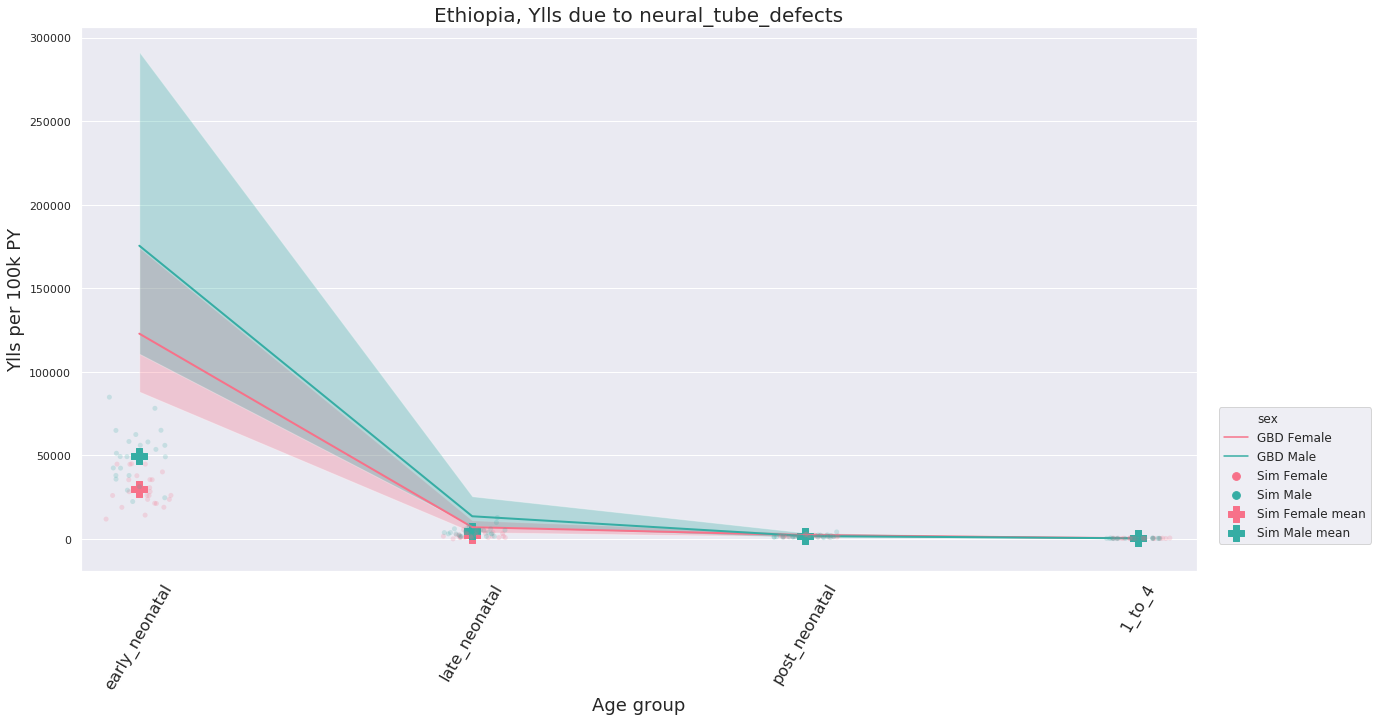

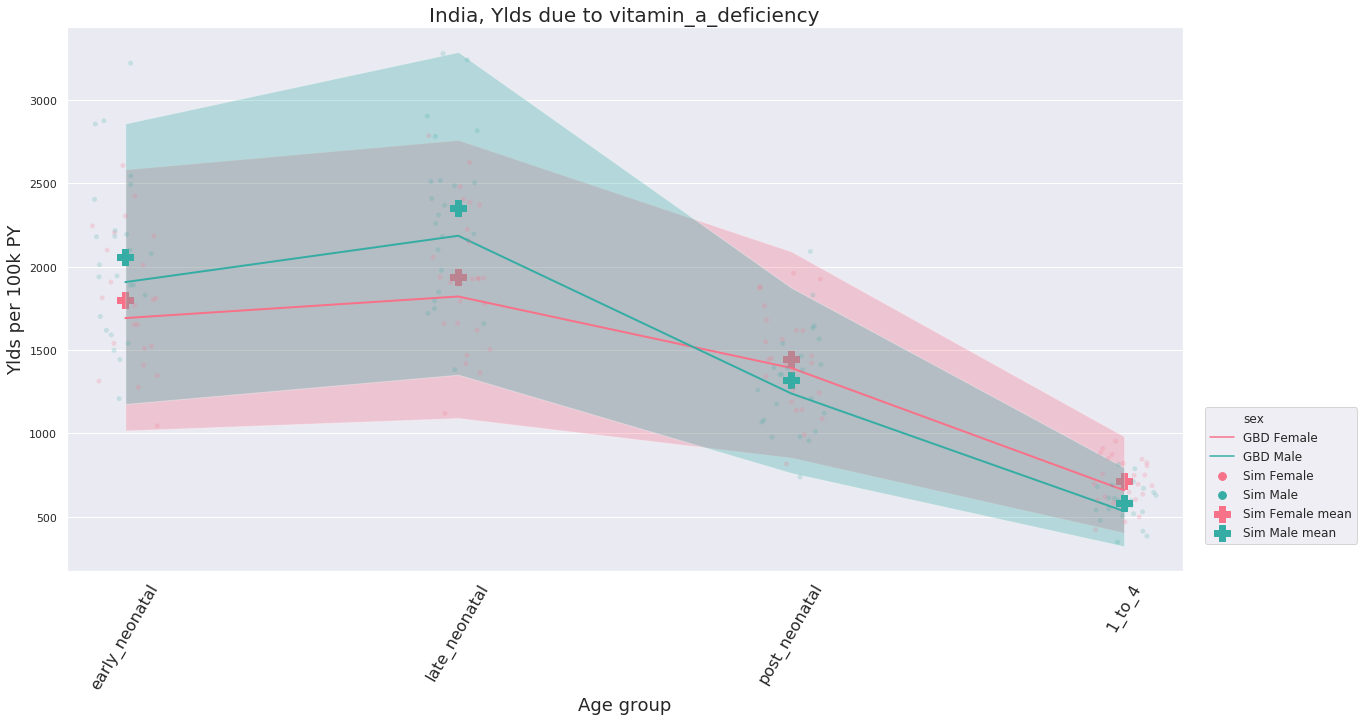

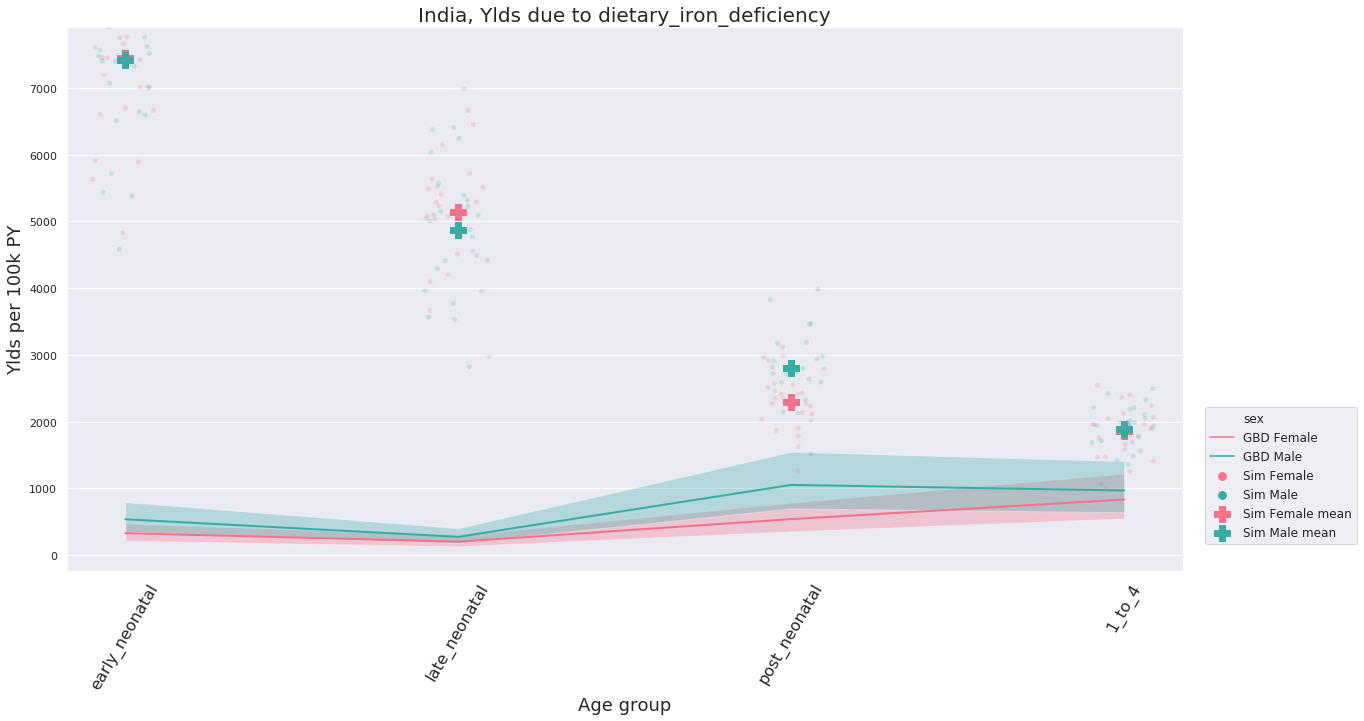

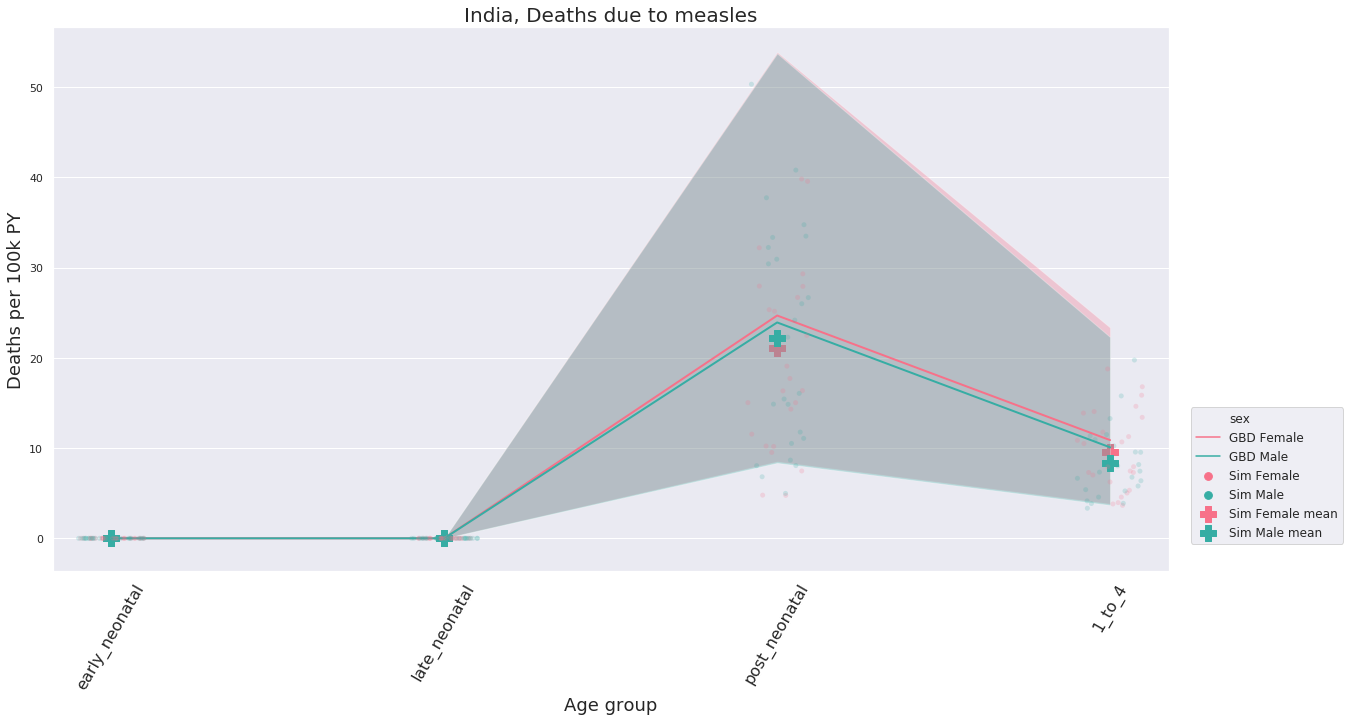

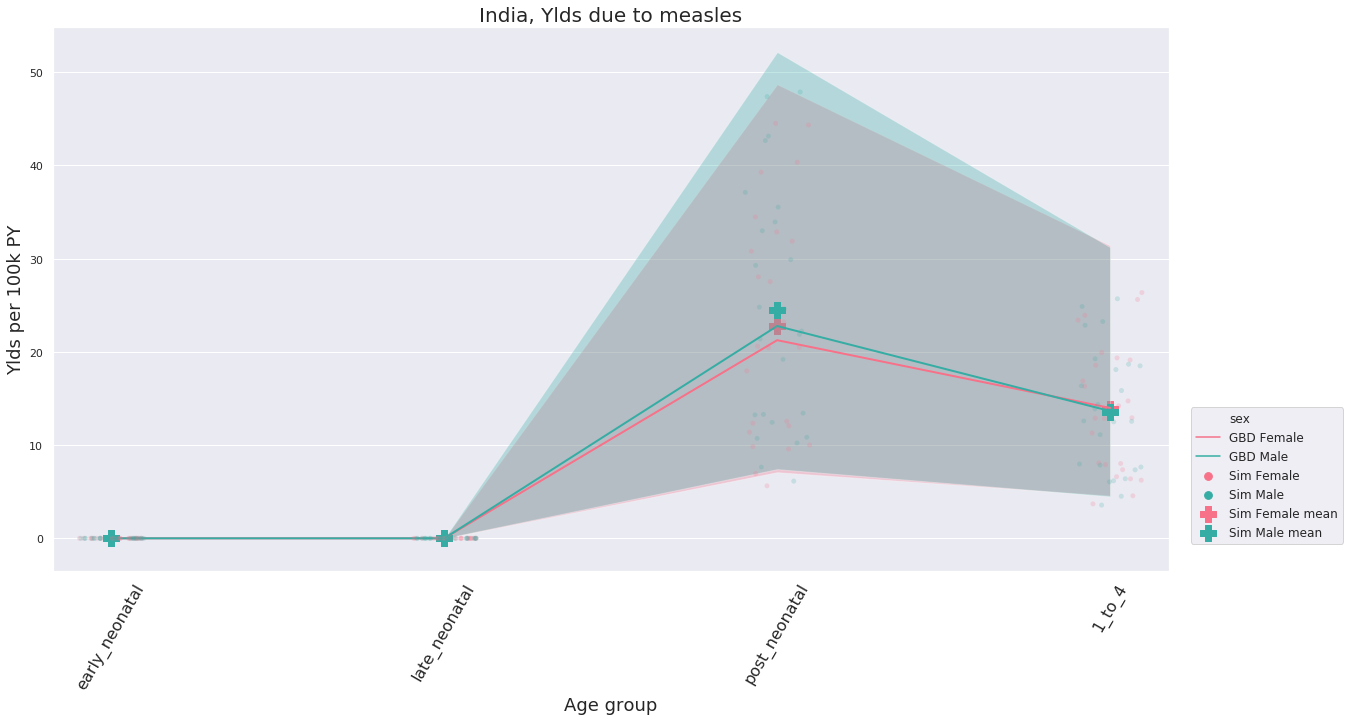

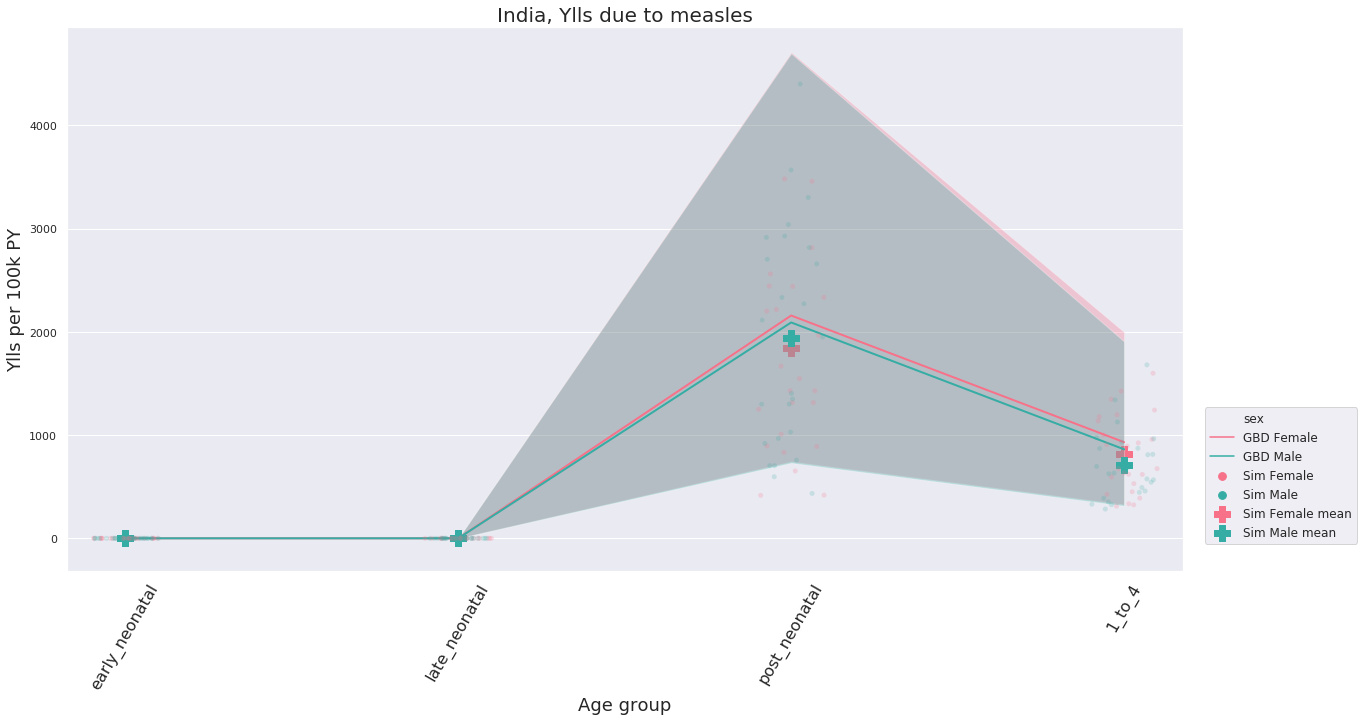

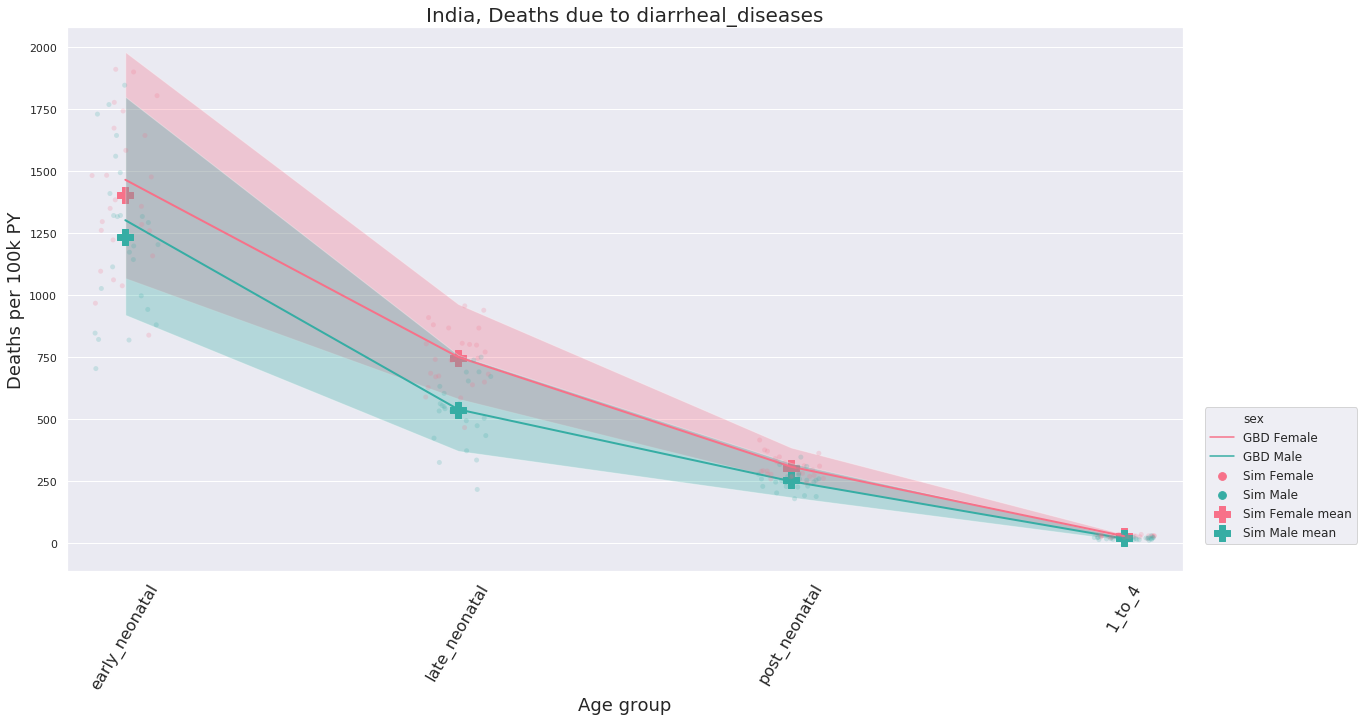

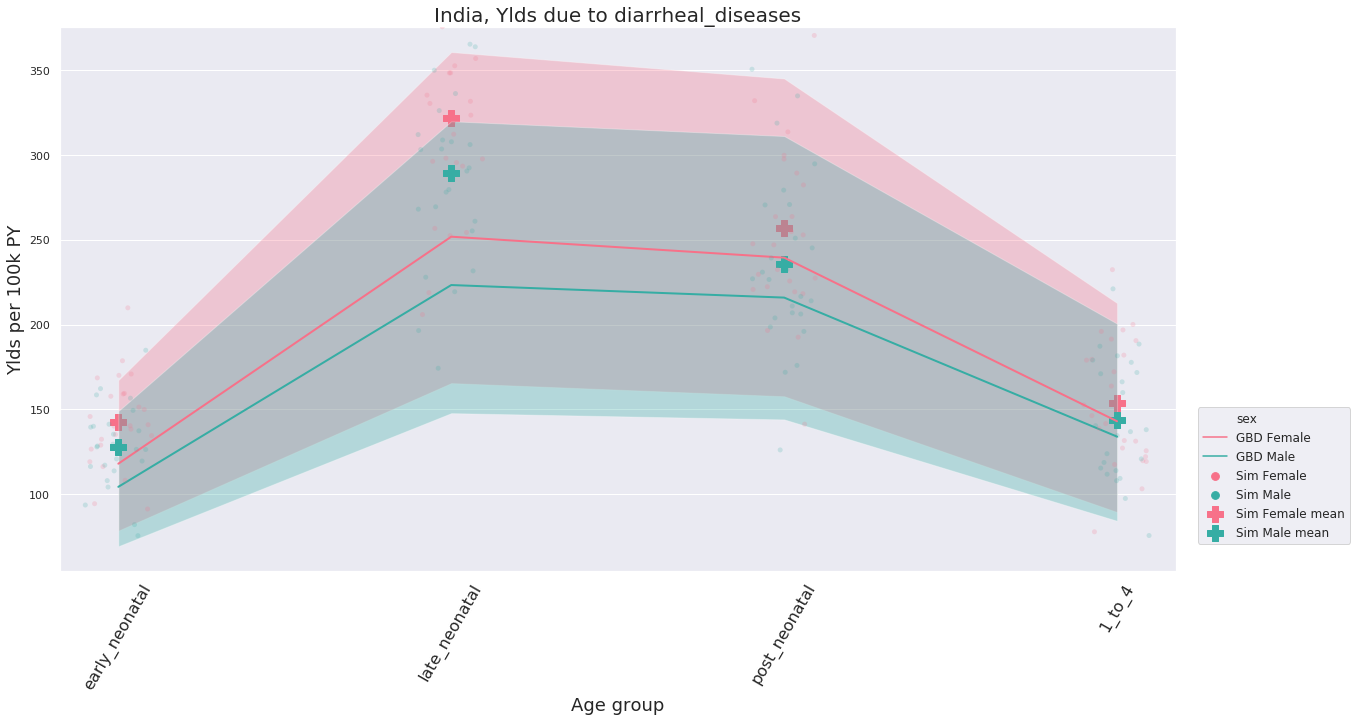

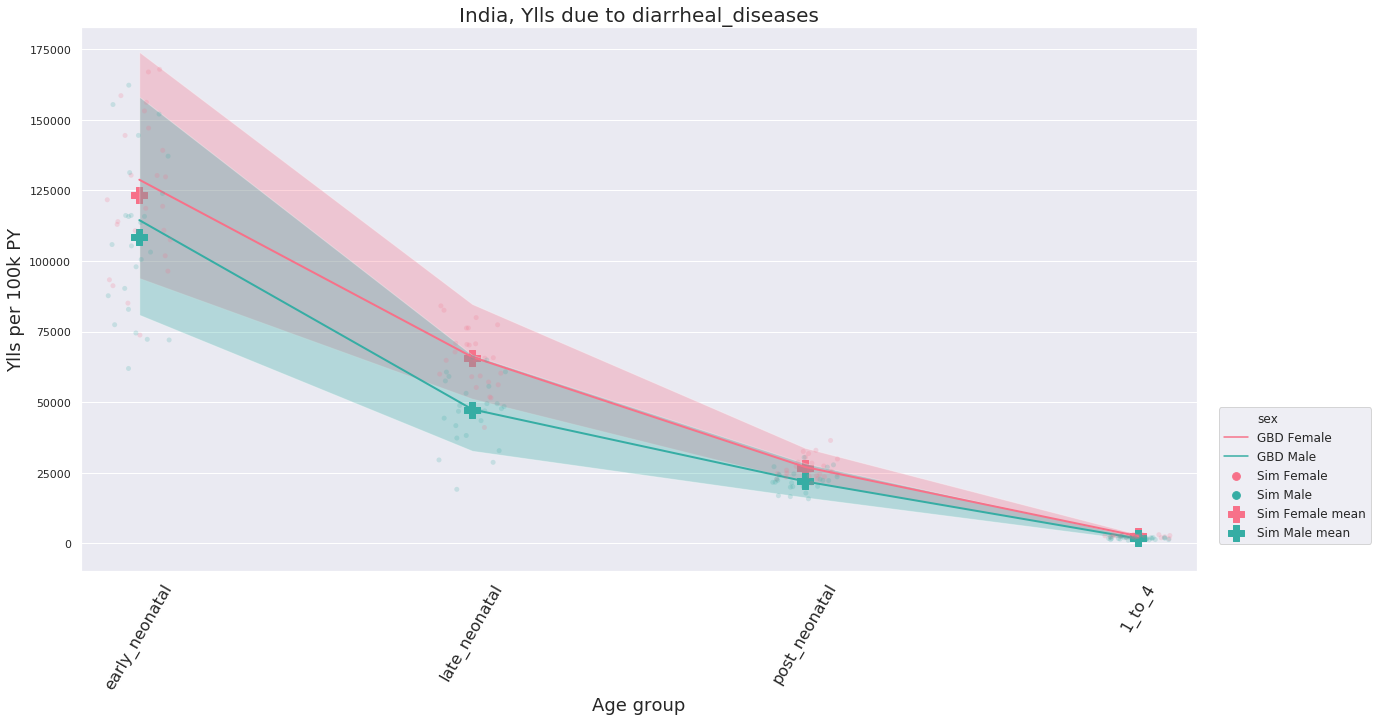

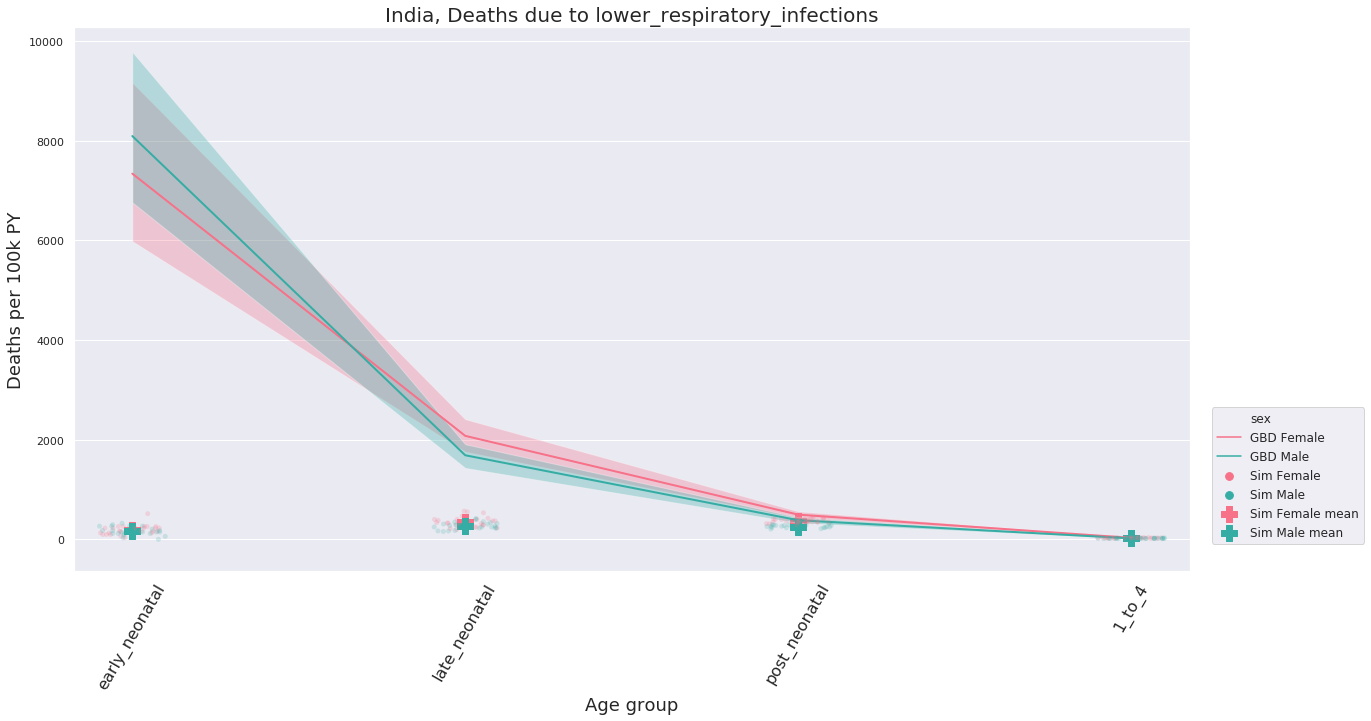

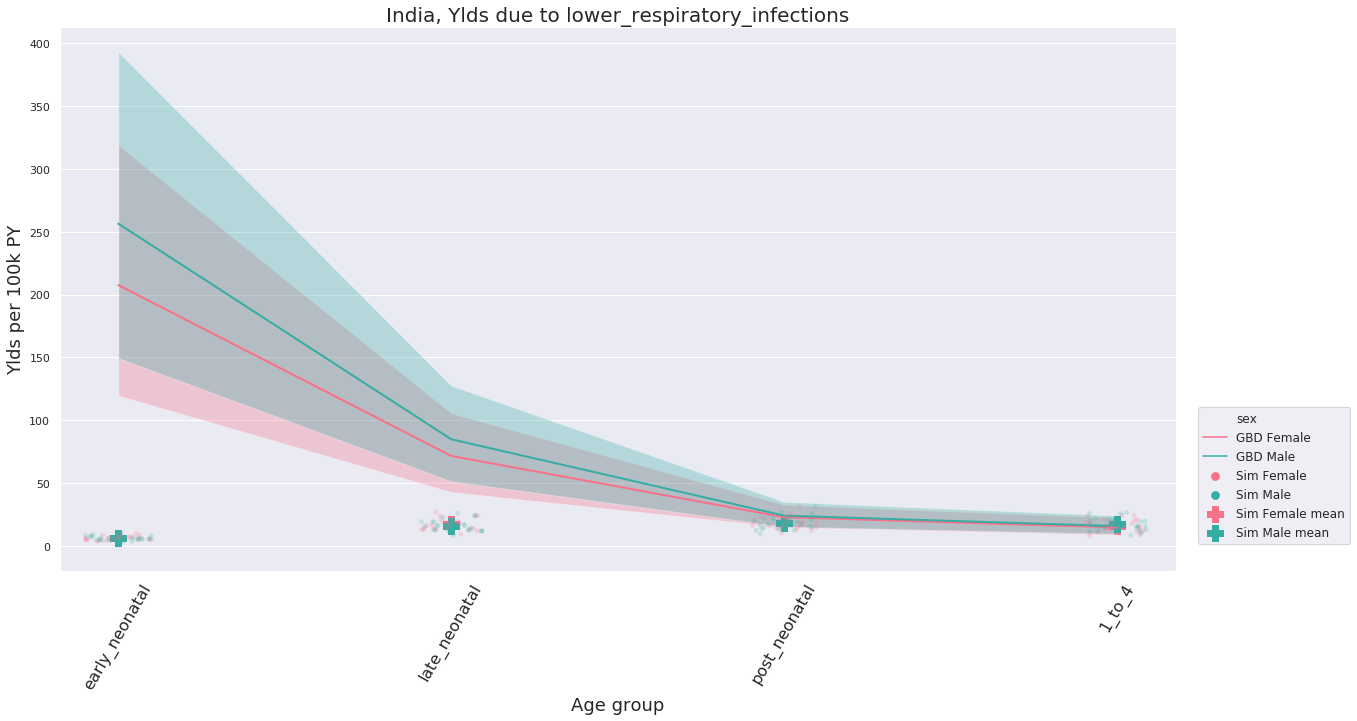

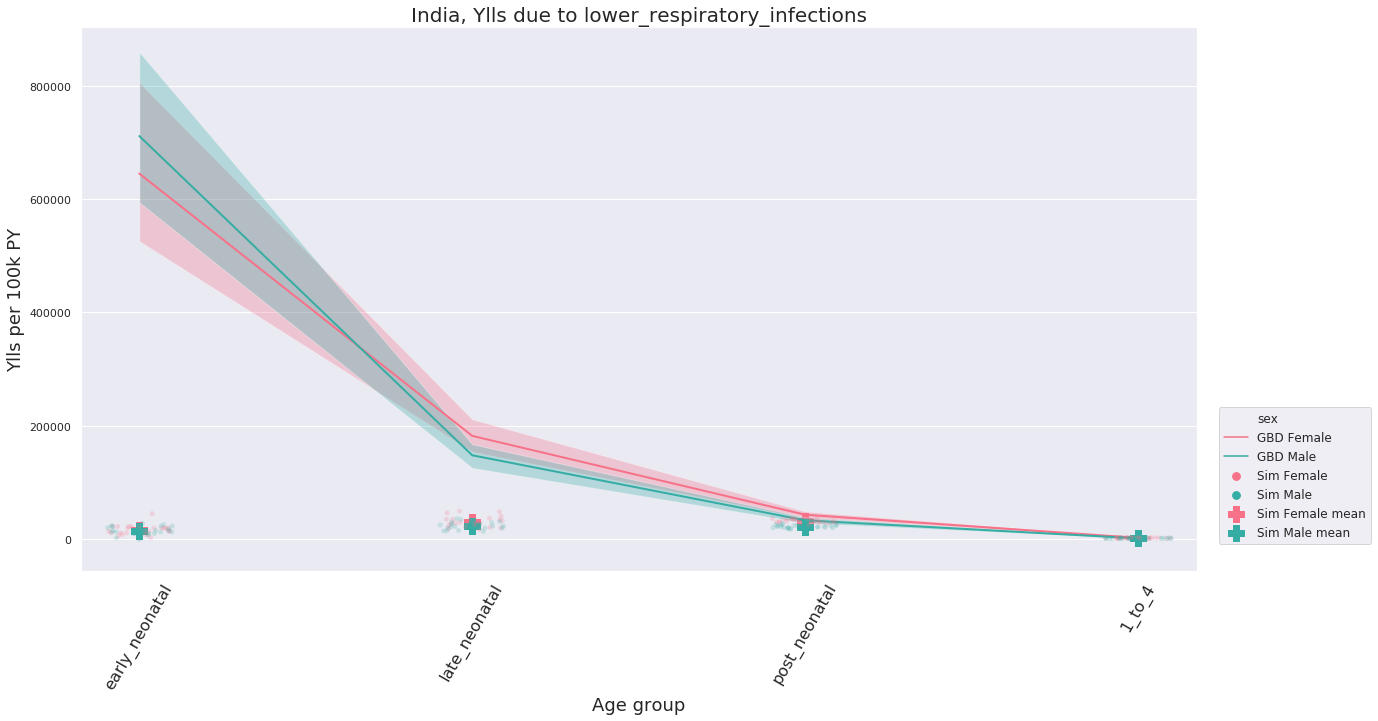

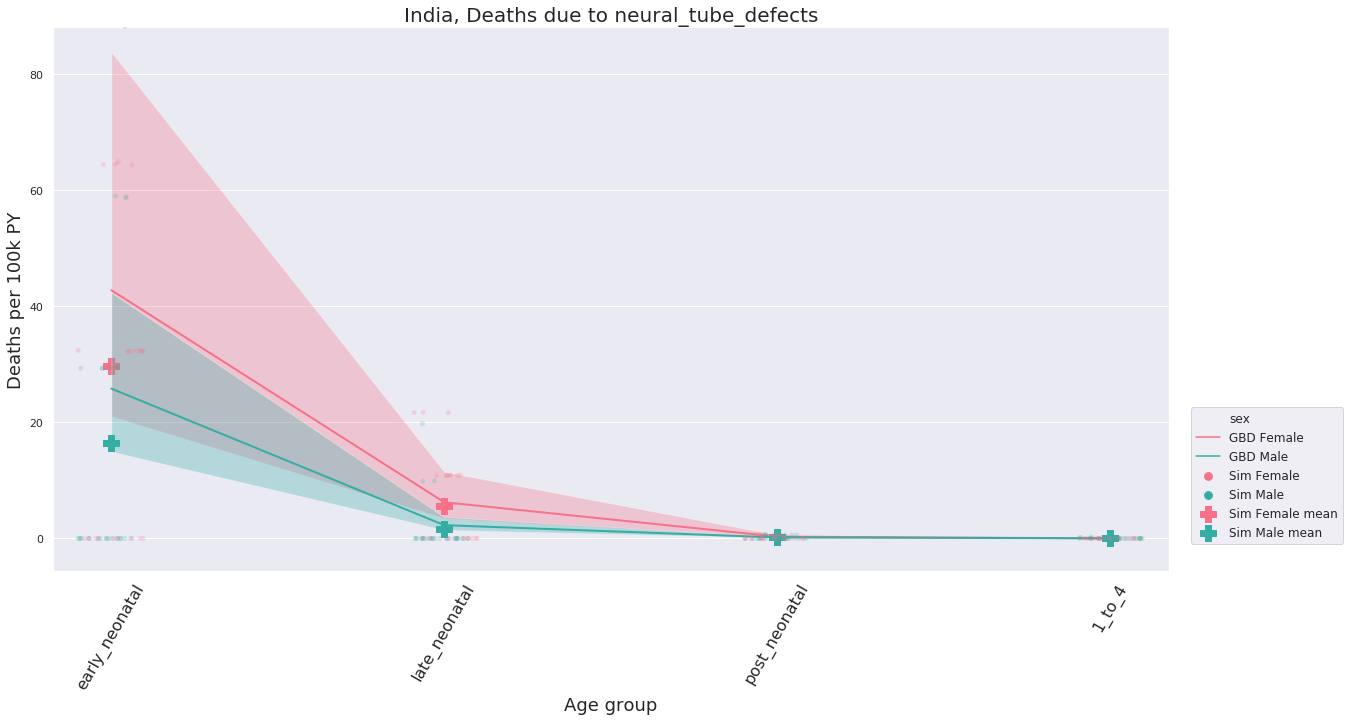

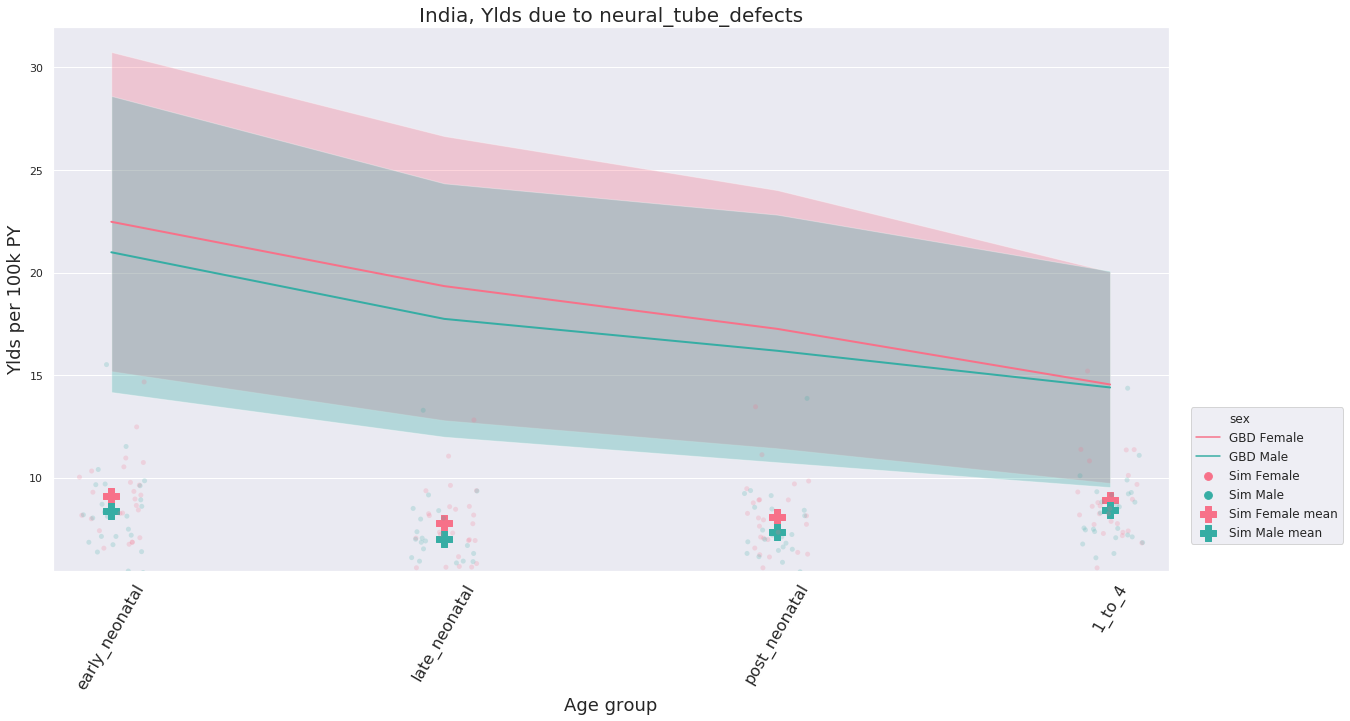

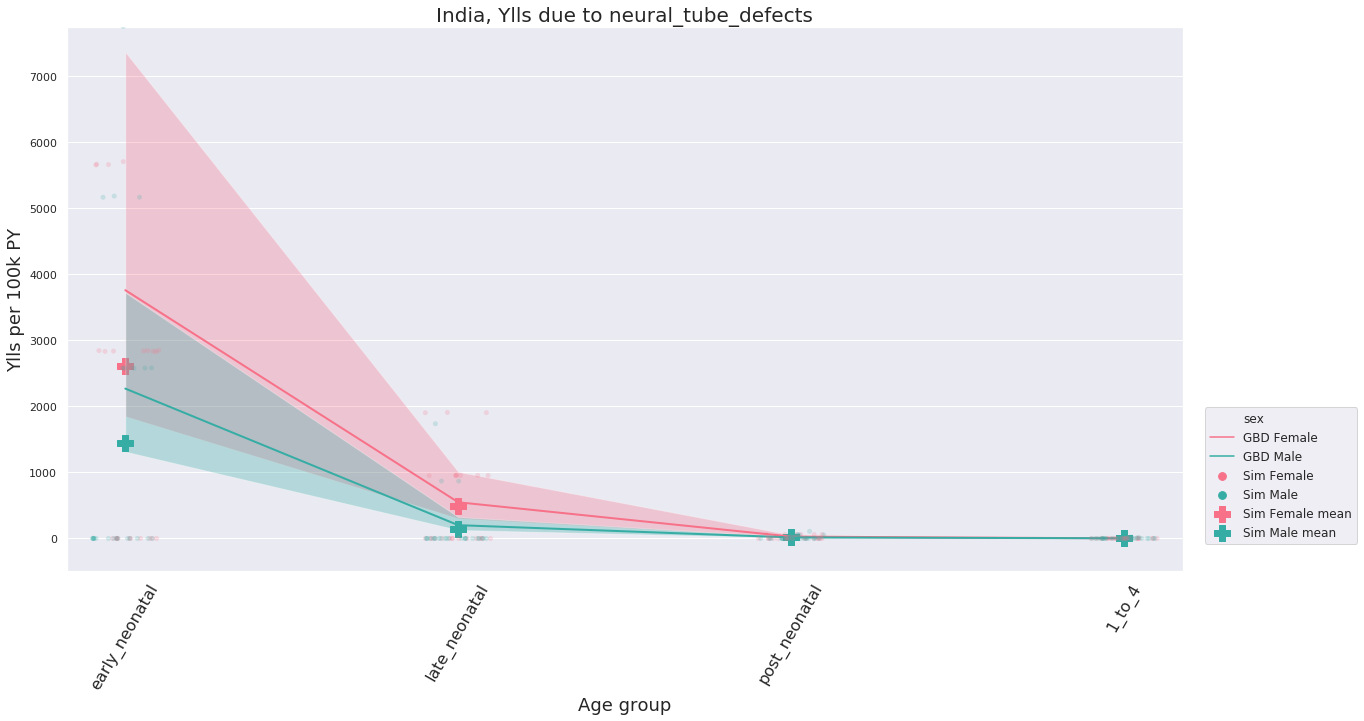

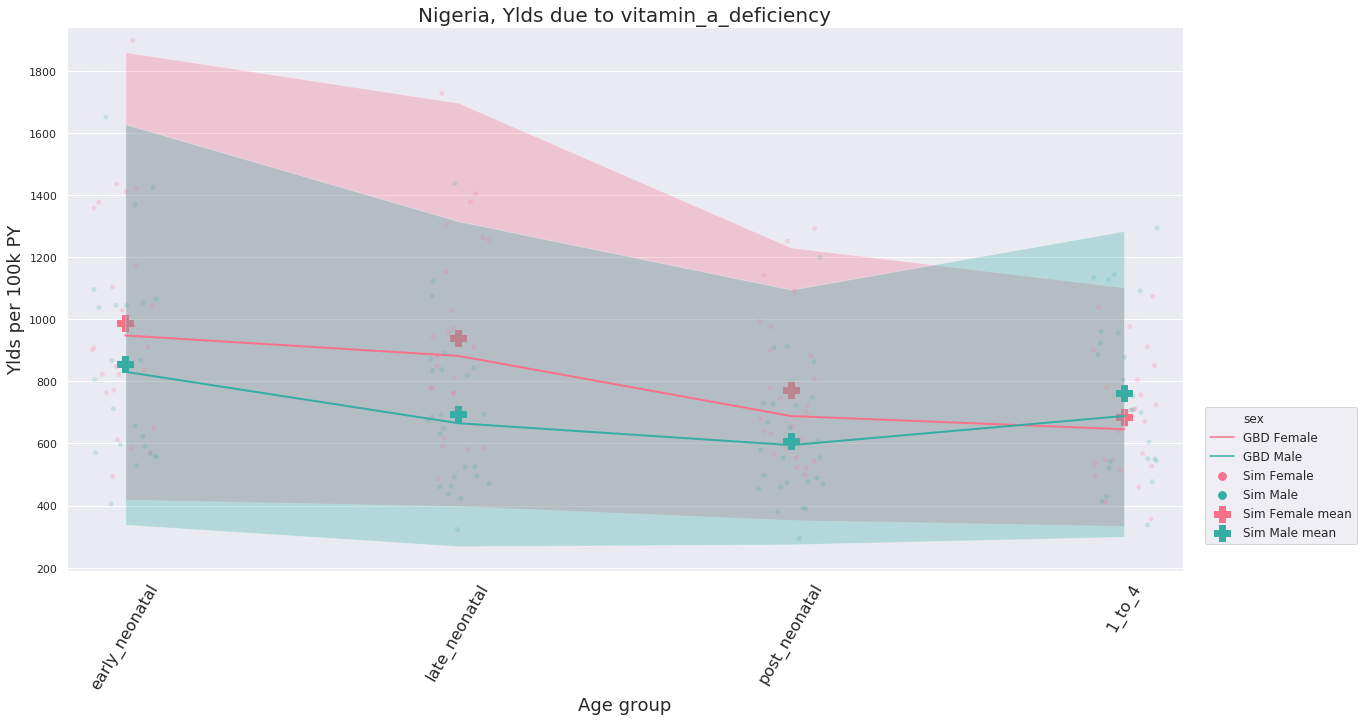

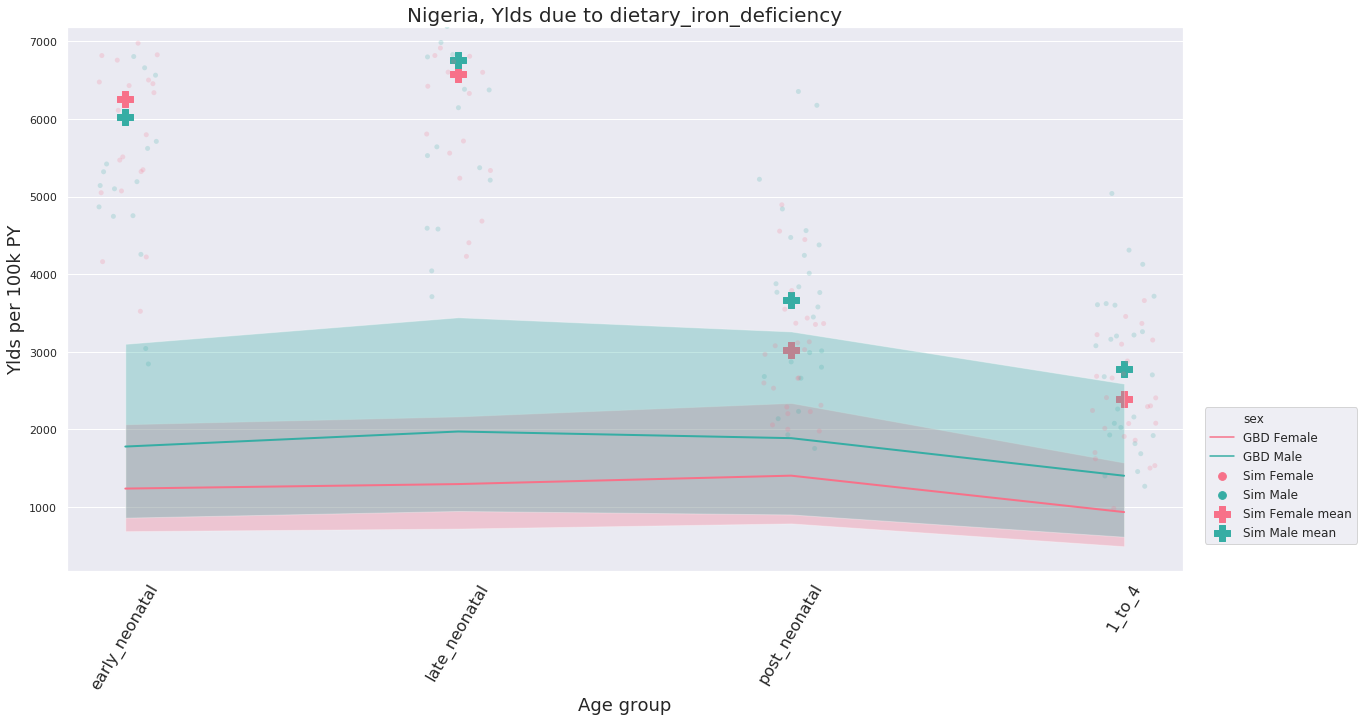

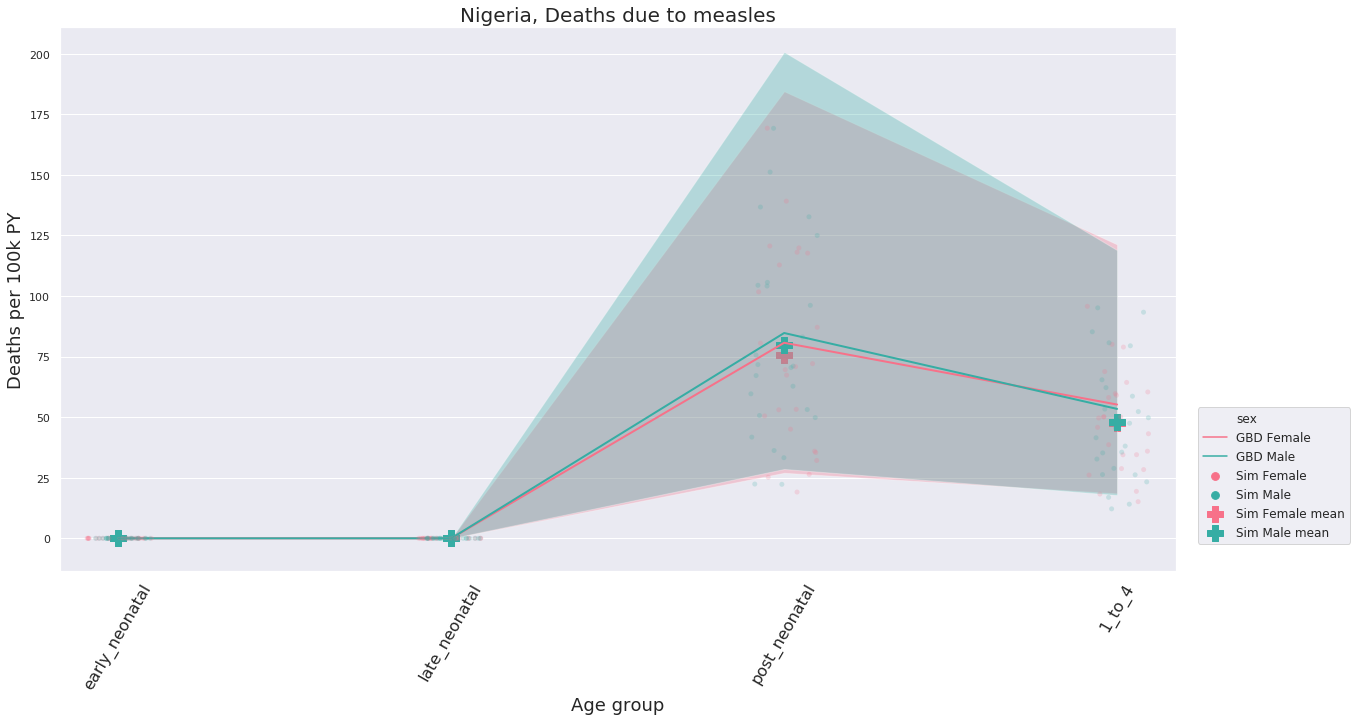

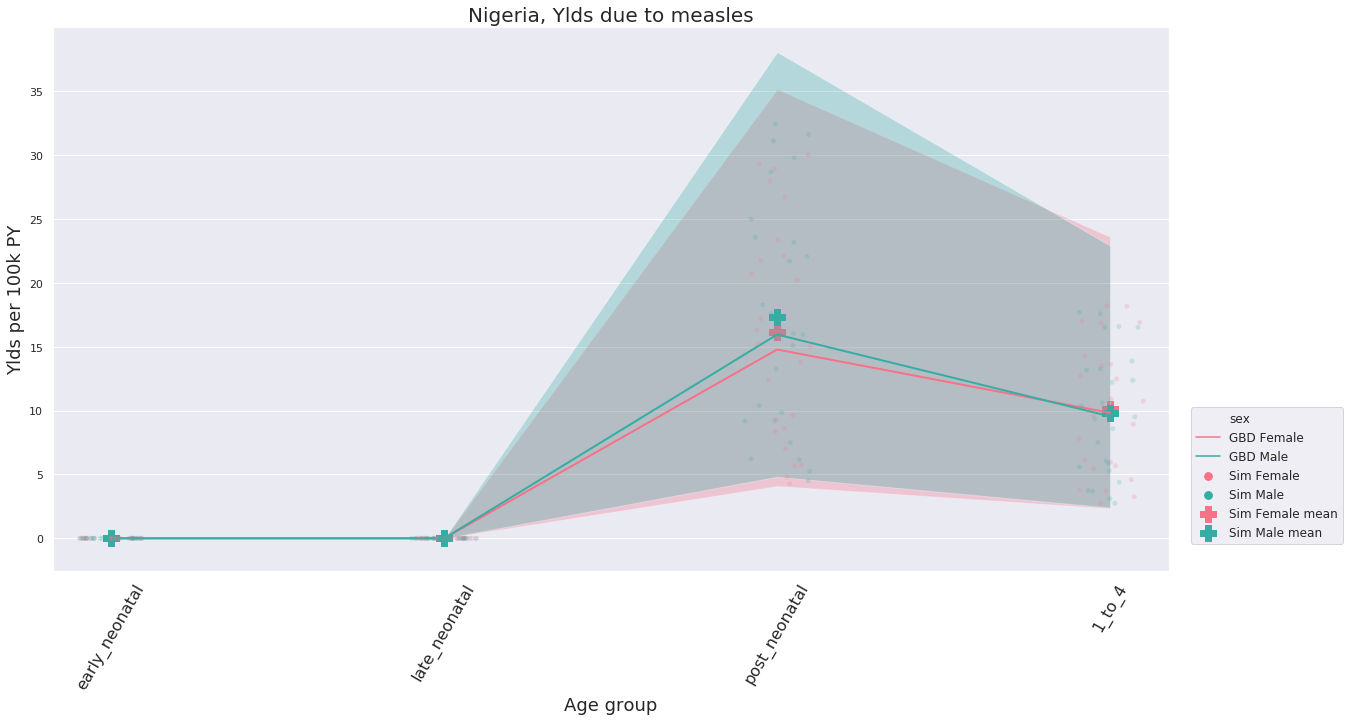

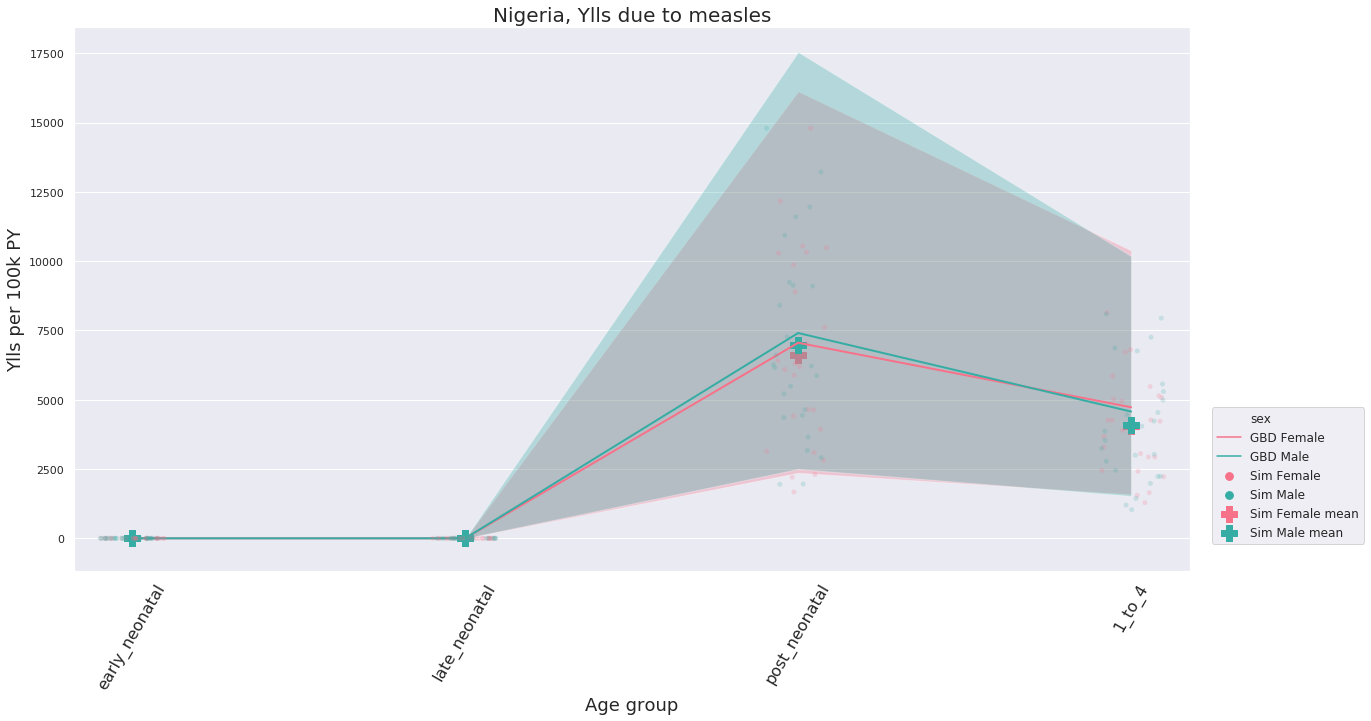

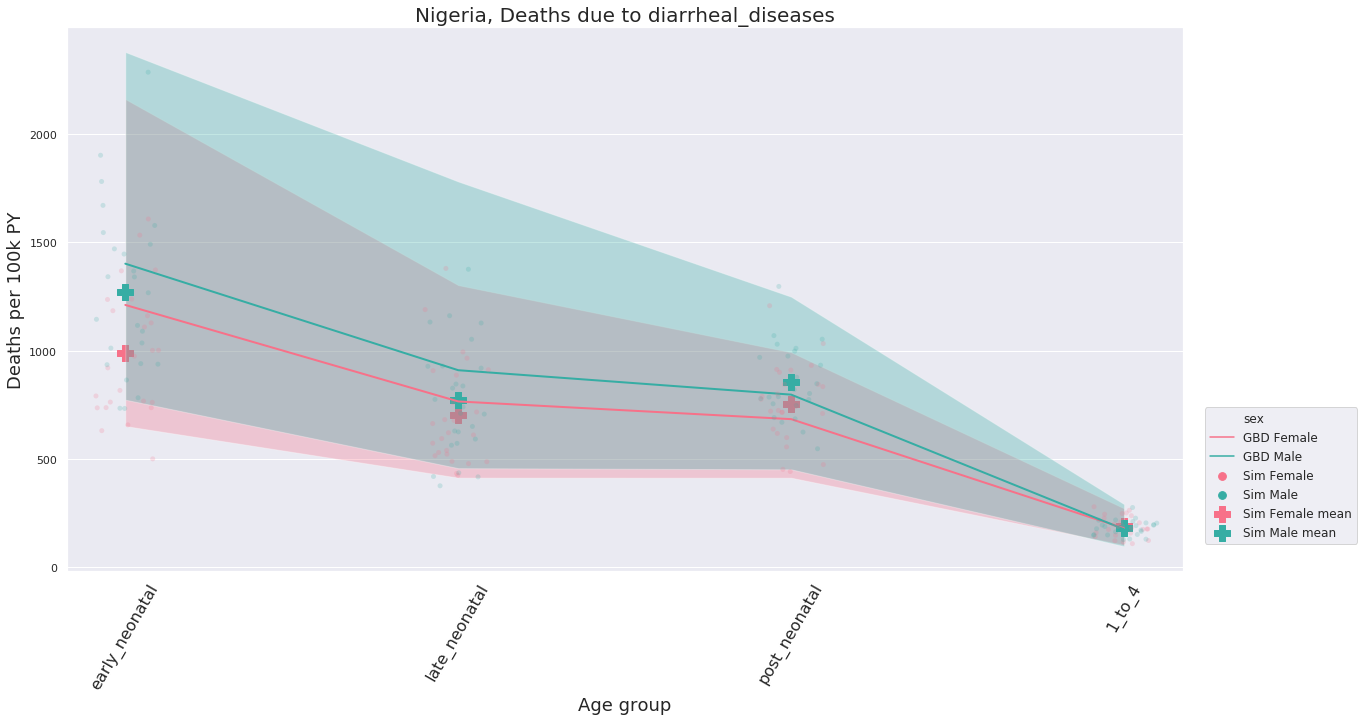

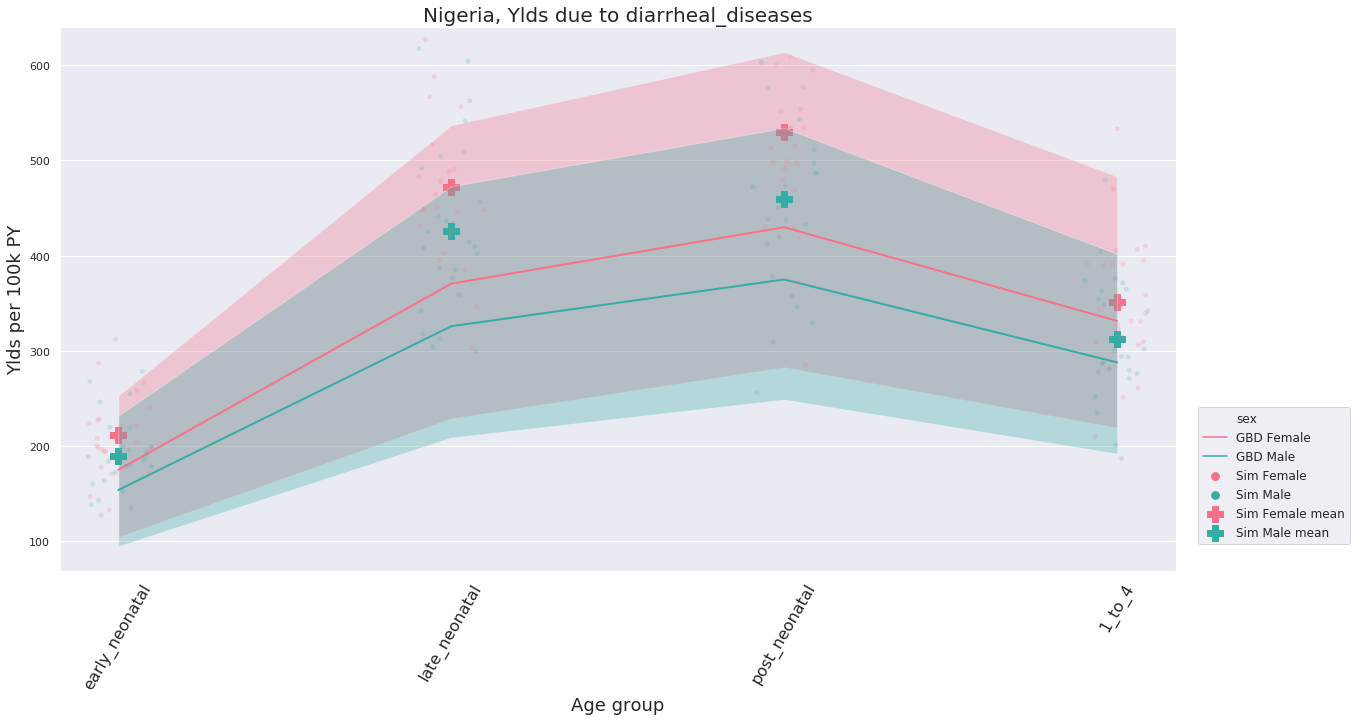

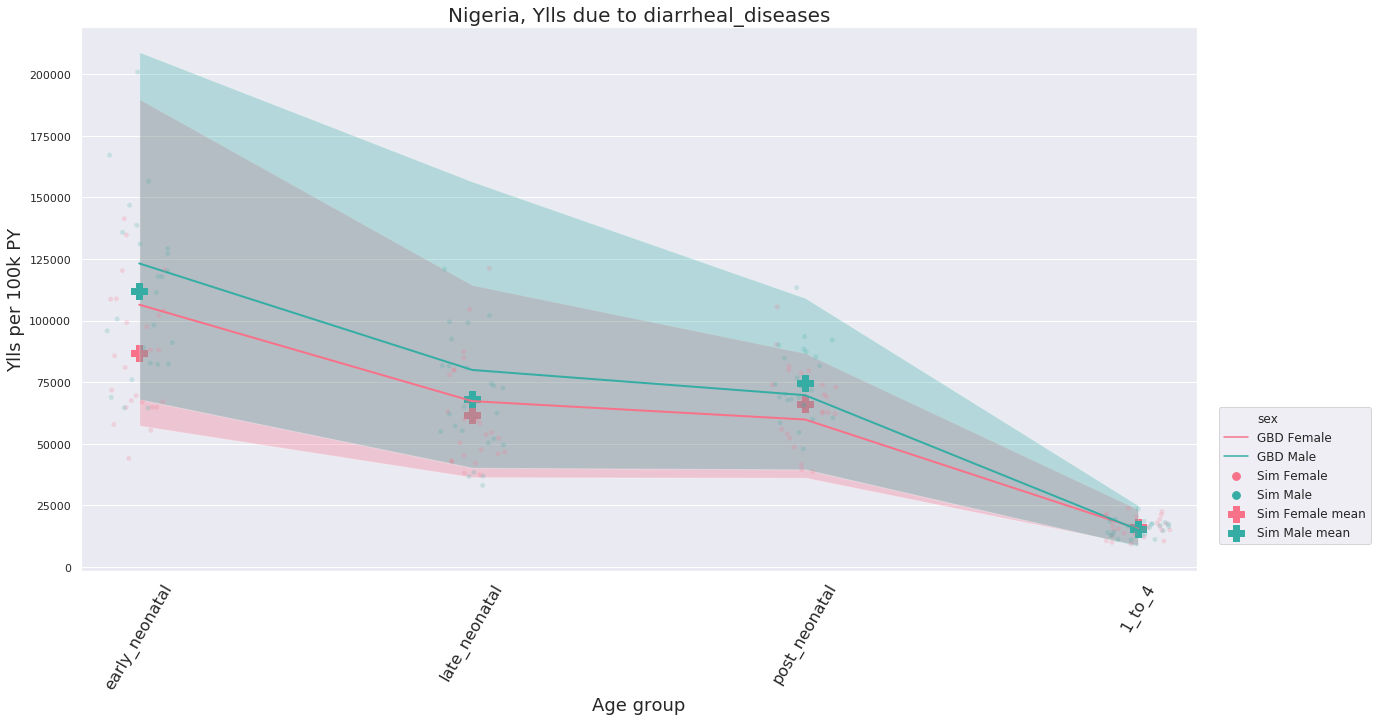

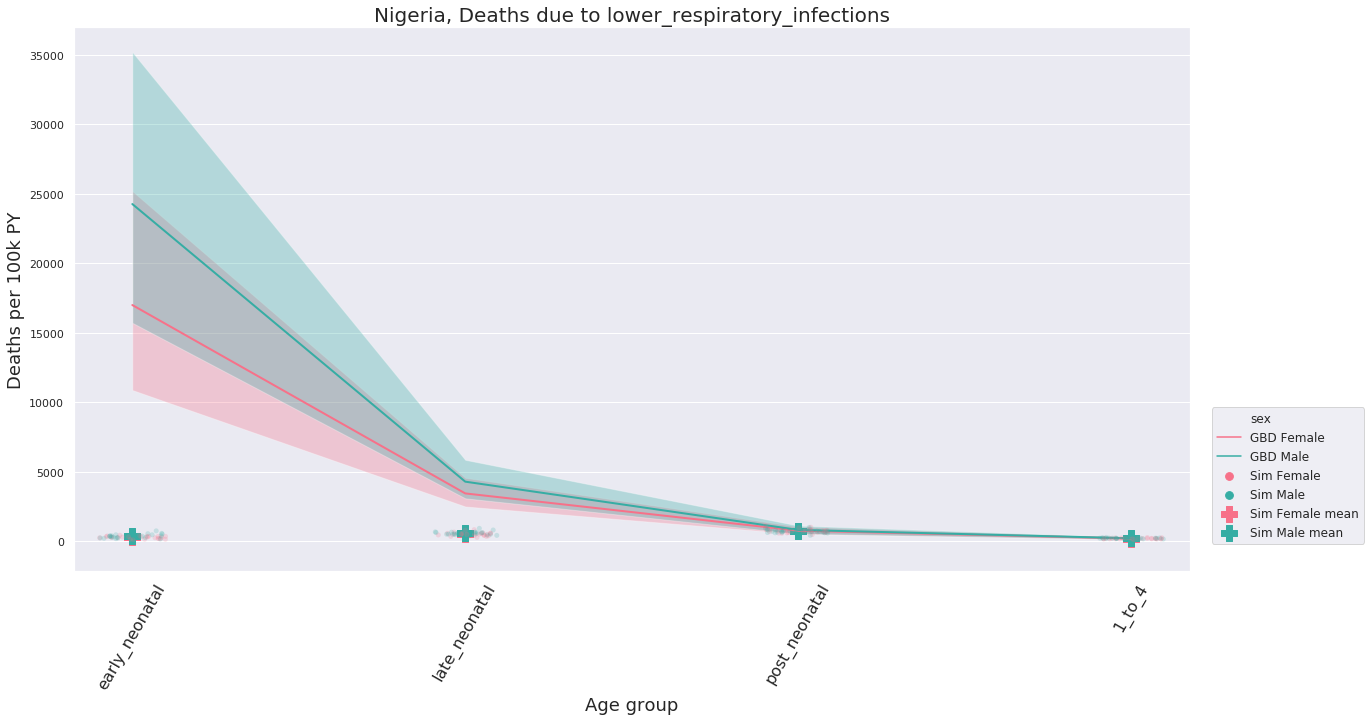

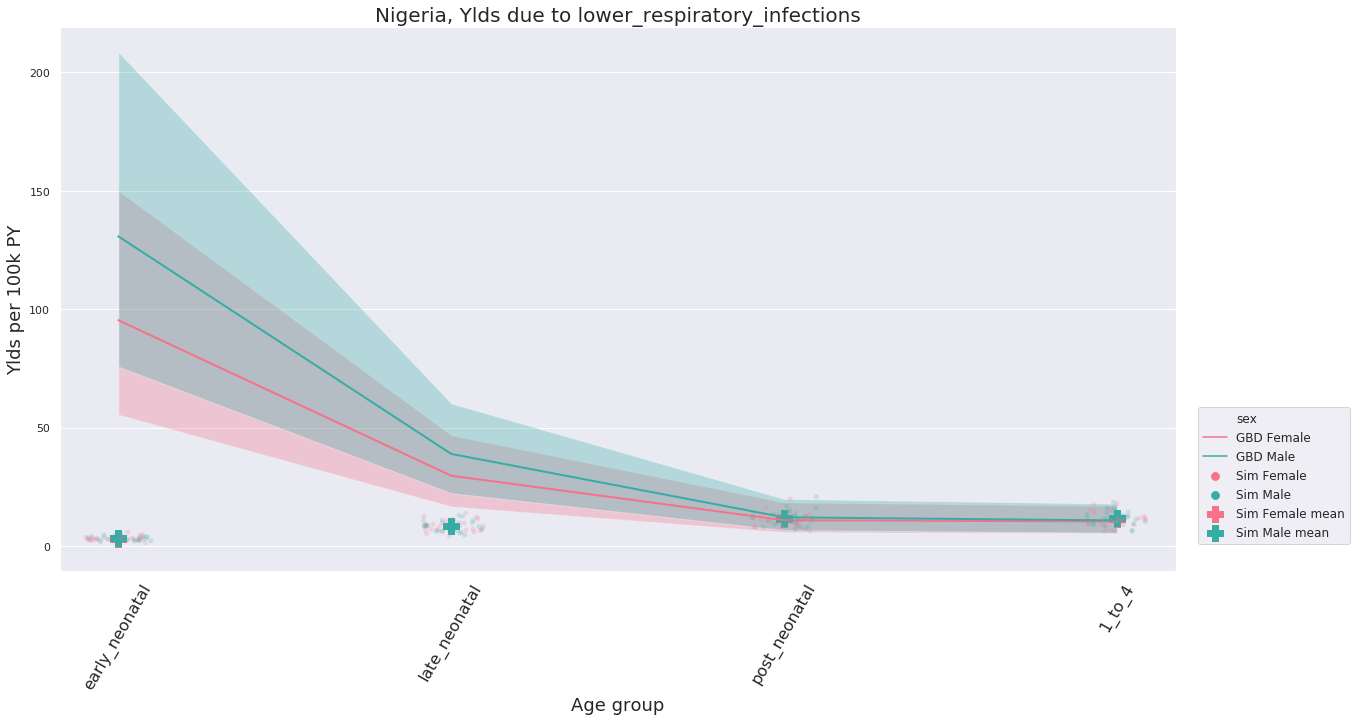

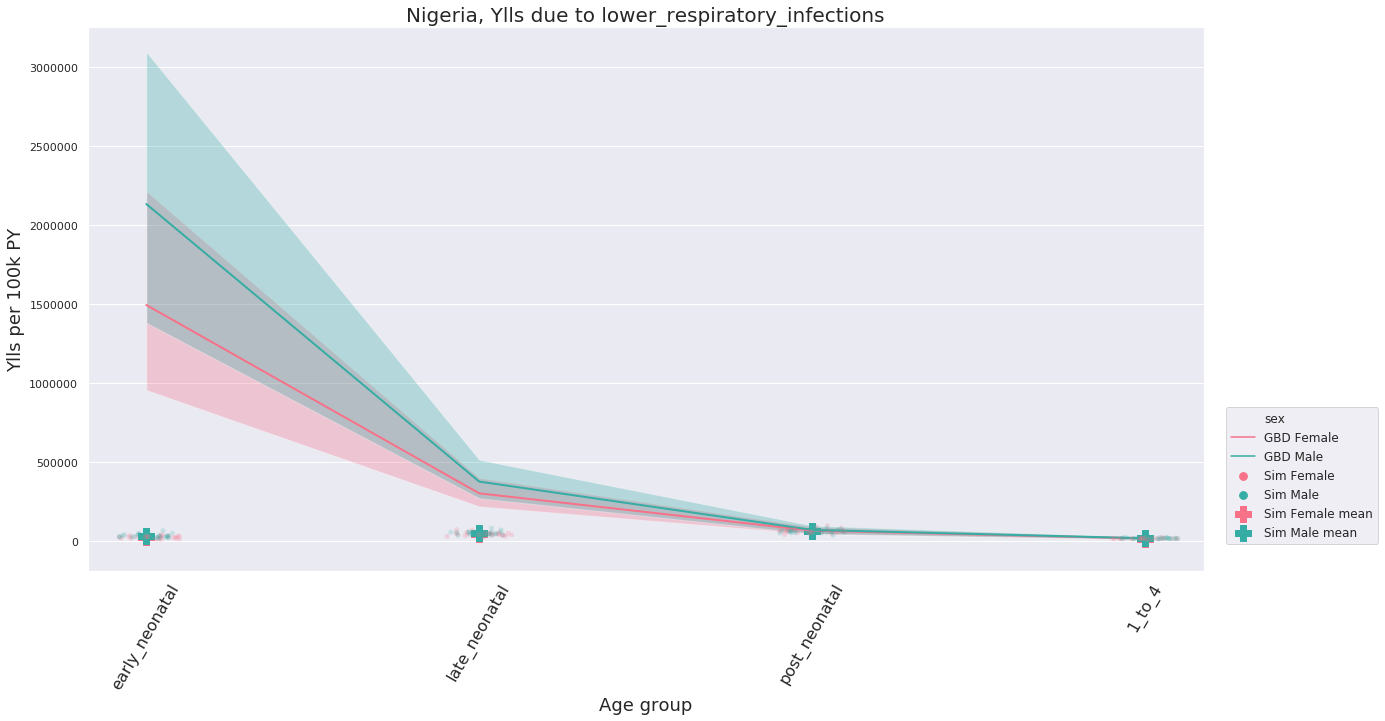

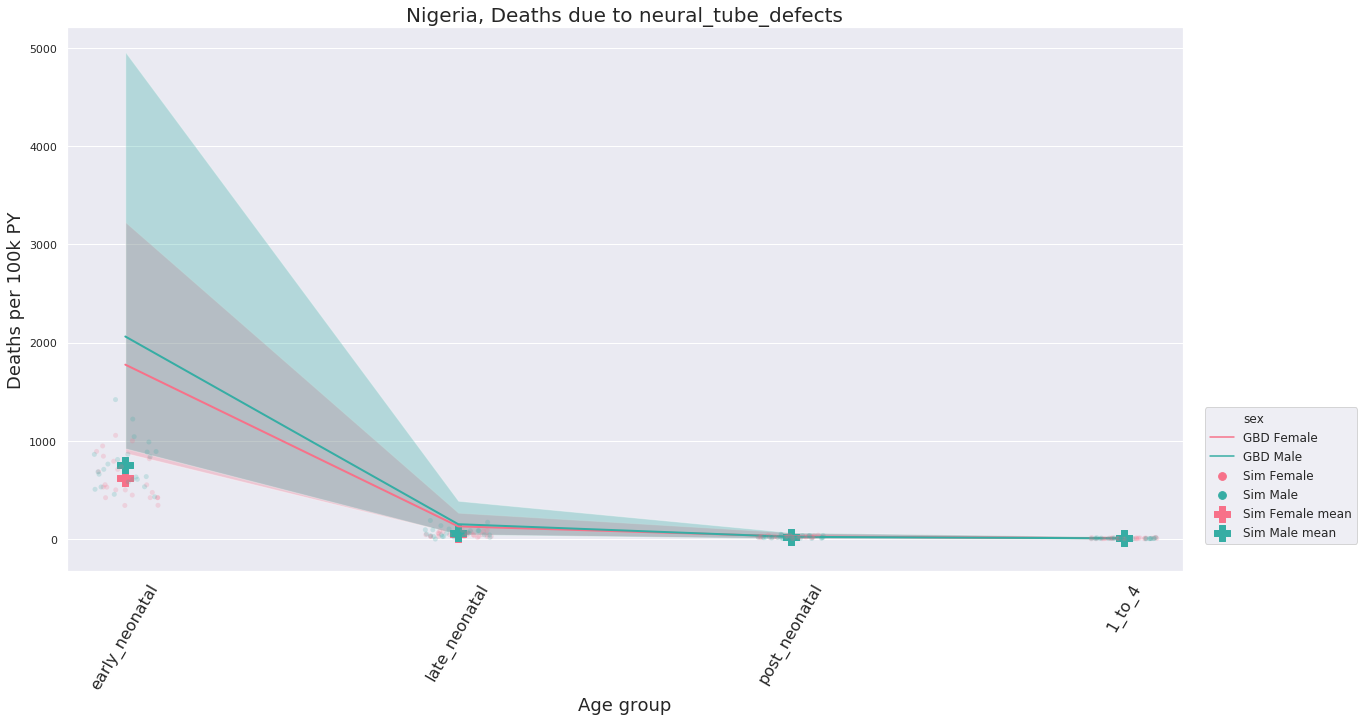

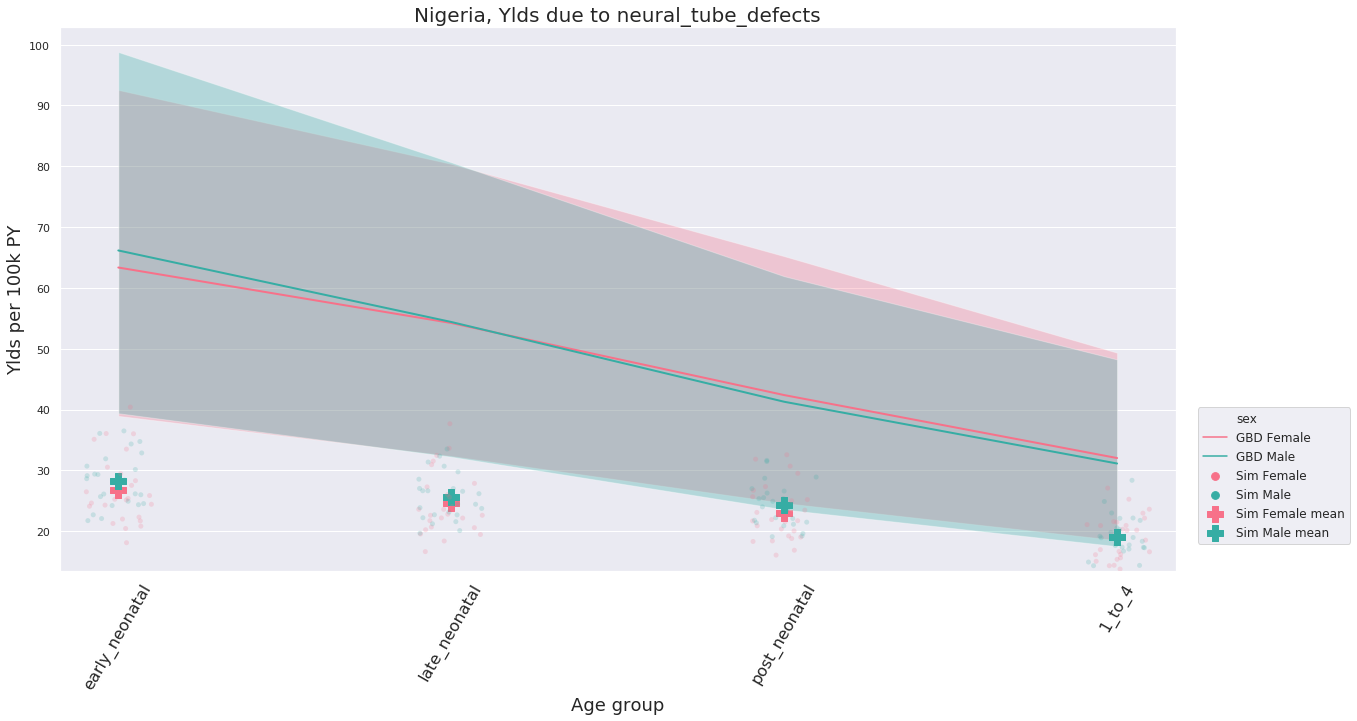

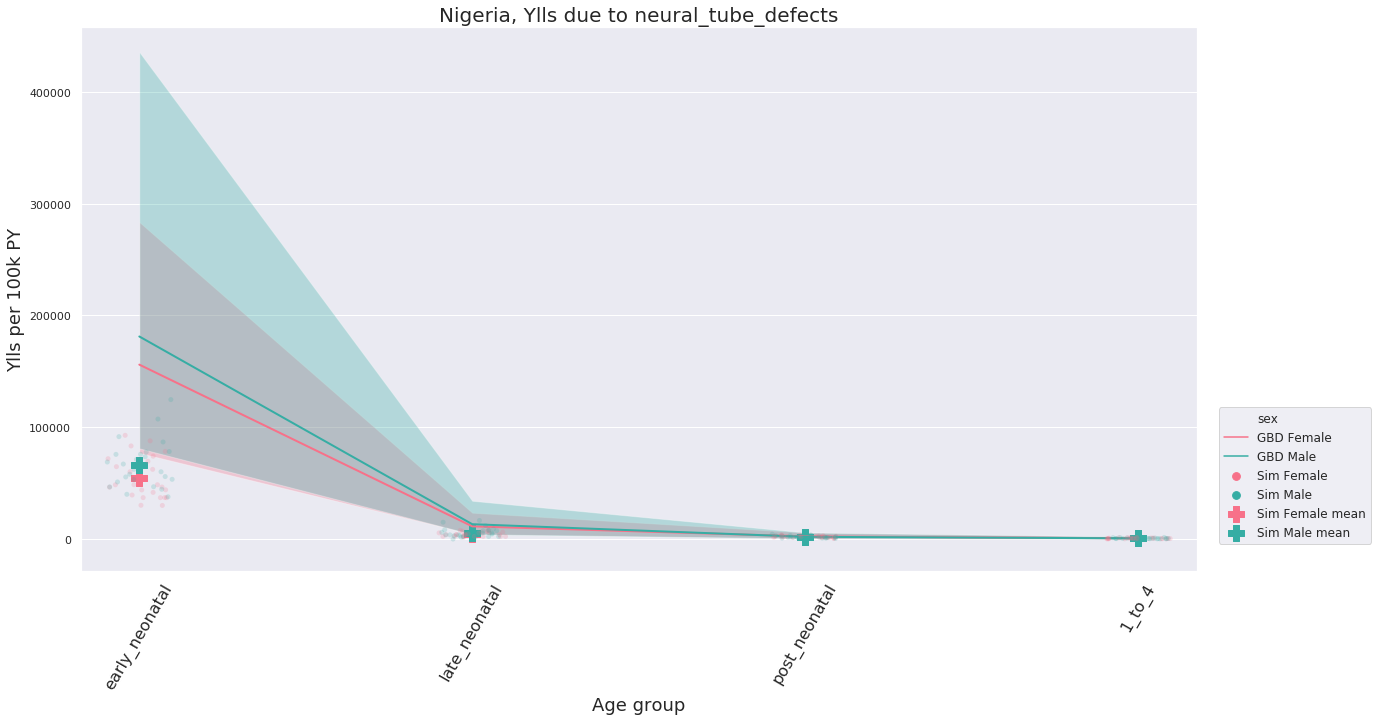

In [12]:
plot_multiple_locations(filePath, cause_names, gbd_names)